# Bias corrections for the csat temperatures -- Bayesian inference

__Problem statement__:

Temperature gradients are a fundamental atmospheric property. However, they are always estimated using (often very) limited point observations at fixed heights. Most commonly these are two thermometers with some fixed distance between the sensors. Sensors with a slow response time are generally more accurate and used for these purposes. Therefore we have: limited and fixed spatial resolution and coarse temporal resolutions relative to Distributed Temperature Sensing (DTS). With vertical profiles of DTS giving fine resolution (1s, 0.1m) temperature observations, we have the opportunity to resolve these gradients in detail for the first time.


Goals of the notebook:
- robustly model stability using a Bayesian Generalized Linera Models (GLM)
- determine appropriate Bayesian hyperparameters and parameters for the GLMs
- prototype how this linear modeling can be compared to Monin-Obukhov Similarity Theory

# 1. Import and formatting

In [6]:
# Data and methods libraries
import numpy as np
import xarray as xr
import scipy.stats
import pandas as pd

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
import copy
import pymc3 as pm
import warnings

## Format plots

In [3]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Define a default color palette, which should be fairly color blind friendly). The
# last purple is a bit similar to the blue for red blindness.
flatui = ["#3498db", "#FFBF00", "#34495e", "#95a5a6", "#e74c3c", "#9b59b6",]
sns.set_palette(sns.color_palette(flatui))

## Directories

In [8]:
dir_pre = os.path.join('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra/')

# Meteorological data
dir_logger_data = os.path.join(dir_pre, 'logger_data')
dir_aws_data = os.path.join(dir_logger_data, 'AWS')
dir_csat_stats = os.path.join(dir_logger_data, 'CSATs', 'stats')
dir_csat_flux = os.path.join(dir_logger_data, 'CSATs', 'fluxes')
dir_csat_corr = os.path.join(dir_logger_data, 'CSATs', 'csat-Ts-correction')
dir_ceil = os.path.join(dir_pre, 'love_dts/ESSD-repository/remote-sensing/ceilometer/')
dir_homogenized_data = os.path.join(dir_pre, 'homogenized_data')

# Figures
dir_print = os.path.join(dir_pre, 'figures', 'AncillaryMet')


# 2. Load data

## 2.1 Homogenized potential temperature data

In [11]:
os.chdir(dir_homogenized_data)

sonic_1min = xr.open_dataset('sonics_pot-temp_1min_qc_tower-subset.v2-2021-06-01.nc')
sonic_10min = xr.open_dataset('sonics_pot-temp_10min_qc_tower-subset.v2-2021-06-01.nc')
aws_2m_theta = xr.open_dataset('aws_pot-temp_1min_qc_tower-subset.v2-2021-06-01.nc')
aws_2m_theta_10min = xr.open_dataset('aws_pot-temp_10min_qc_tower-subset.v2-2021-06-01.nc')
tower = xr.open_dataset('tower_pot-temp_1s_qc_tower-subset.v2-2021-06-01.nc')
tower_1min = xr.open_dataset('tower_pot-temp_1min_qc_tower-subset.v2-2021-06-01.nc')
tower_10min = xr.open_dataset('tower_pot-temp_10min_qc_tower-subset.v2-2021-06-01.nc')

## 2.2 Ancillary data

Ceilometer and the automatic weather station

- Ceilometer for cloudiness
- AWS for radiation and RH

In [12]:
os.chdir(dir_ceil)
ceilo = xr.open_dataset('ceiolometer-combined-files_2019_June01-Aug15.nc')
ceilo = ceilo.reindex_like(sonic_1min_sub.time, method='nearest')

In [13]:
os.chdir(dir_aws_data)
aws = xr.open_dataset('AWS_Voi_1min.nc')

# 3. Temperature Gradients

The fundamental quantity for temperature gradients is $\frac{dT}{dz}$

## 3.1 Generate a time series of ols log-linear fitting

In [14]:
# Pre-allocate the ols parameters in the 10 min tower Dataset
tower_10min['ols_m'] = (('time'), np.zeros(len(tower_10min.time.values)))
tower_10min['ols_r'] = (('time'), np.zeros(len(tower_10min.time.values)))
tower_10min['ols_p'] = (('time'), np.zeros(len(tower_10min.time.values)))
tower_10min['ols_b'] = (('time'), np.zeros(len(tower_10min.time.values)))

z_range = np.arange(0.5, 12, 0.25)

for t in tower_10min.time:
    ds_tower = tower_10min.sel(time=t).theta_mean

    result_dts = scipy.stats.linregress(np.log(ds_tower.z), ds_tower.values)
    tower_10min['ols_m'].loc[{'time': t}] = result_dts.slope
    tower_10min['ols_r'].loc[{'time': t}] = result_dts.rvalue
    tower_10min['ols_p'].loc[{'time': t}] = result_dts.pvalue
    tower_10min['ols_b'].loc[{'time': t}] = result_dts.intercept

### 3.1.1 Quickly visualize the time series of ols log-linear slopes

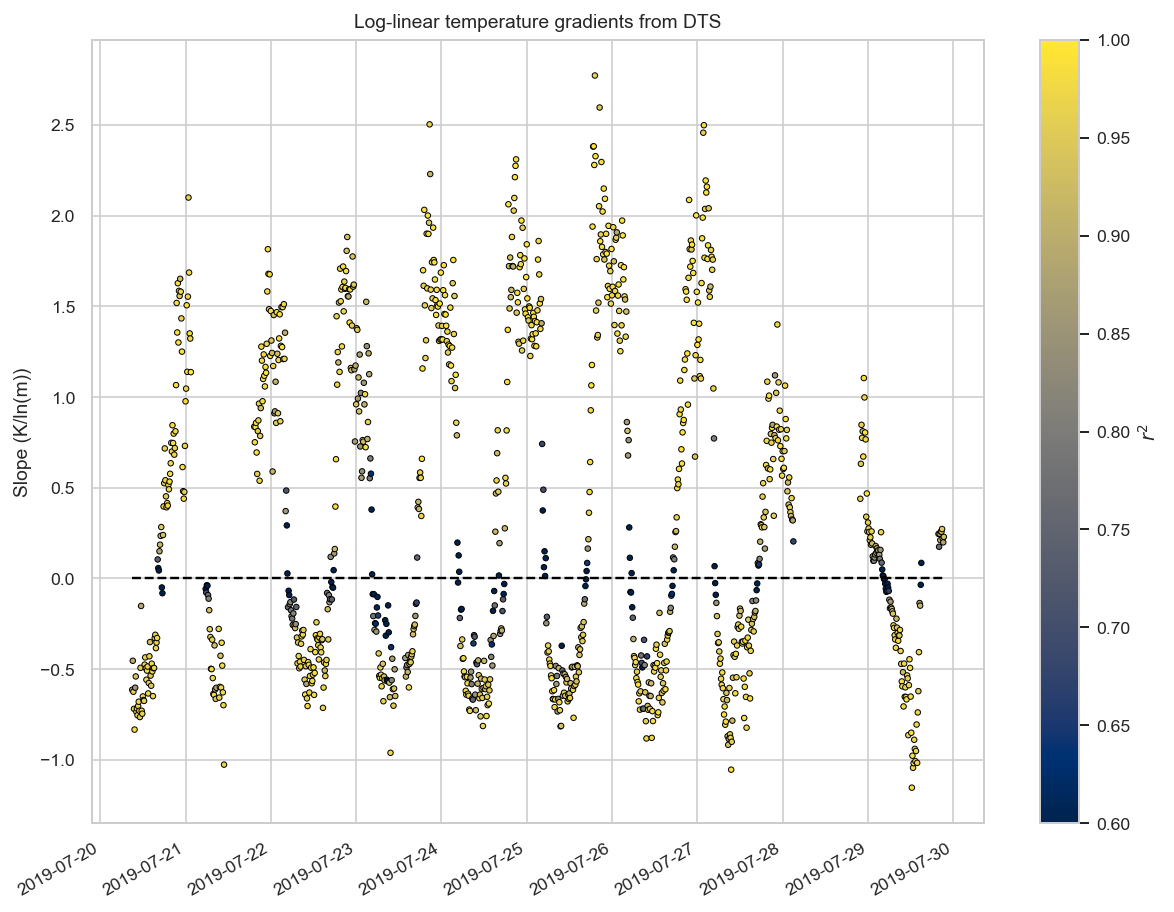

In [18]:
plt.figure(figsize=(10, 8))
im = plt.scatter(
    tower_10min.time.values,
    tower_10min.ols_m.values,
    30,
    tower_10min.ols_r.values ** 2,
    marker='.', 
    cmap='cividis',
    vmin=0.6,
    vmax=1,
    edgecolor='k',
    linewidth=0.5
)
plt.plot([tower_10min.time.values[0], tower_10min.time.values[-1]], [0, 0], 'k--')
plt.gca().set_ylabel('Slope (K/ln(m))')
plt.gca().set_title('Log-linear temperature gradients from DTS')
cbar = plt.gcf().colorbar(im)
cbar.set_label('$r^2$')
plt.gcf().autofmt_xdate()

The distribution of $R^2$ towards periods with a slope of zero (neutral conditions) makes some sense, as the slope is zero. But, it also suggests that we need a better linear fit algorithm. Let's briefly investigate if that is the case.

### 6.1.2 Visualizing the temperature gradients with the poorer fit

I'll just use a random subset of 9 of the 10 min intervals to see what sort of features drive the poorer linear relationships ($R^2 < 0.8$)

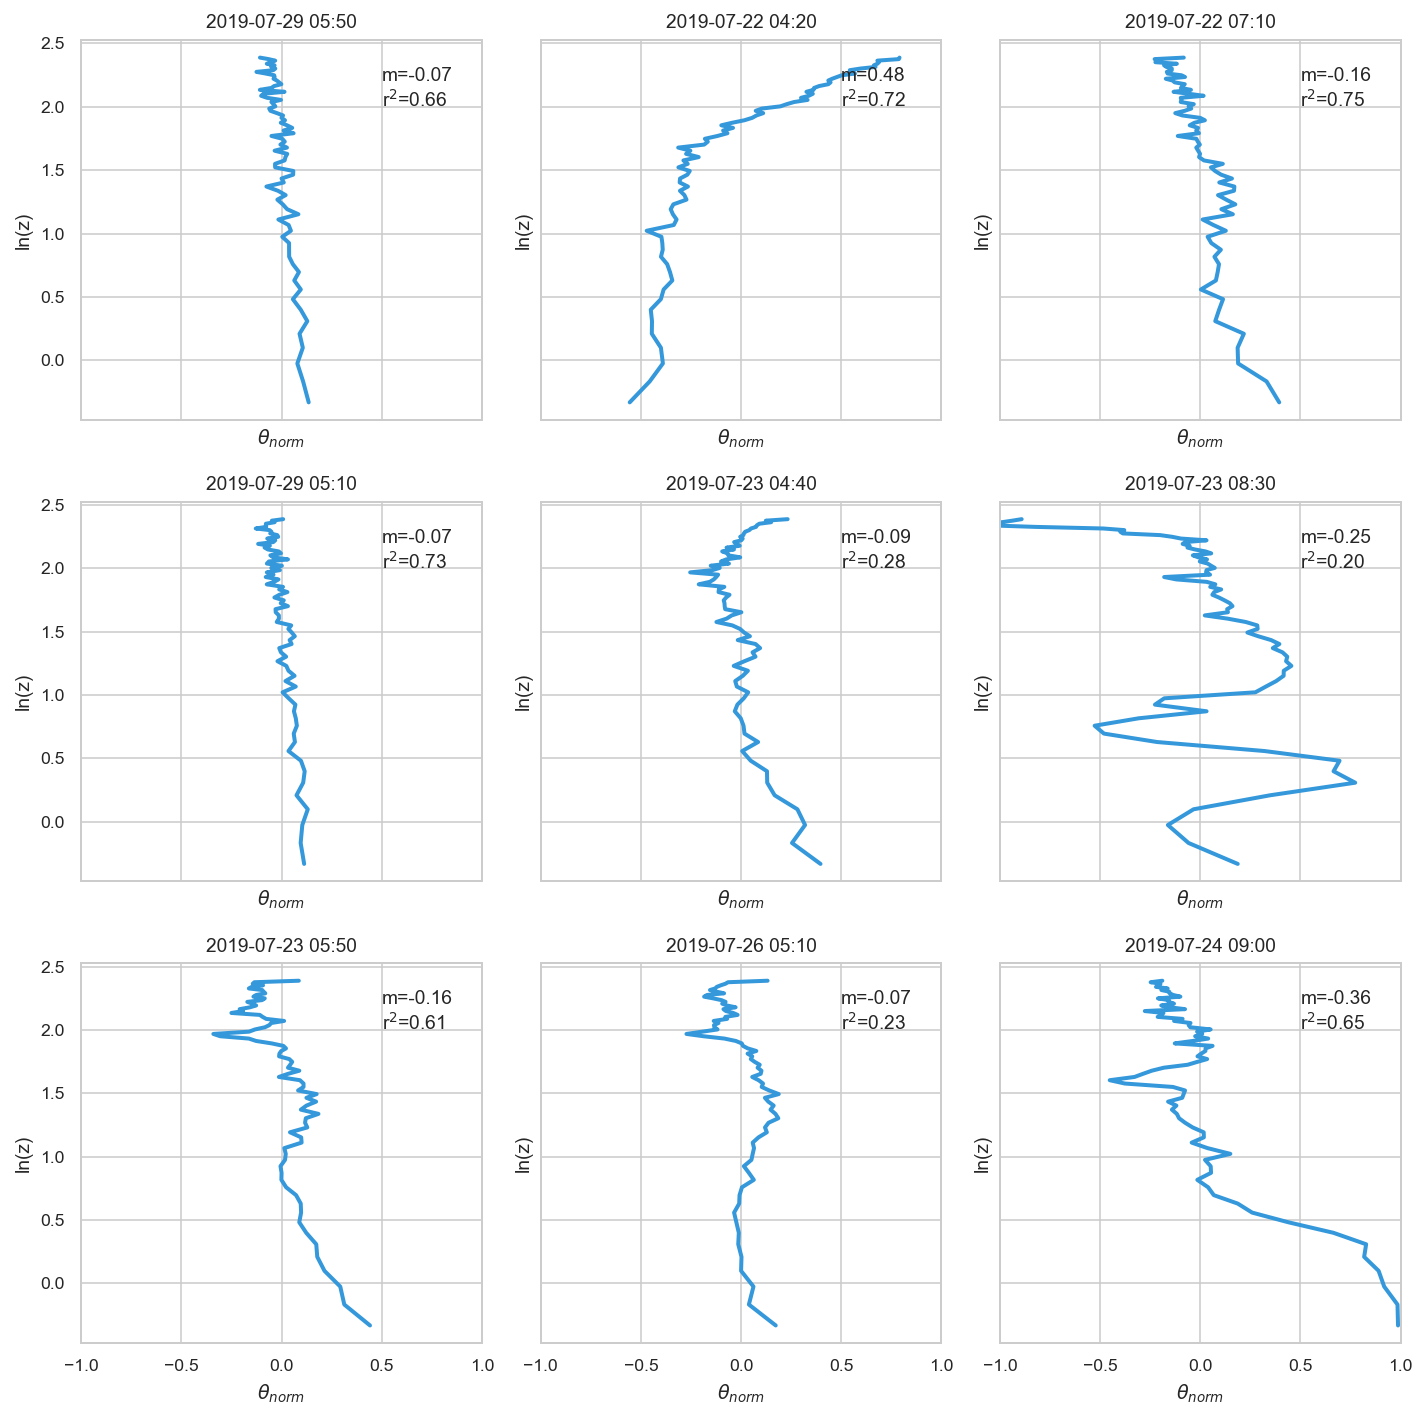

In [25]:
from numpy.random import default_rng


ind = (tower_10min.ols_r ** 2) < 0.8
ds = tower_10min.where(ind, drop=True)

rng = default_rng()
samp = rng.choice(len(ds.time.values), size=9, replace=False)

fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(10, 10))
axes = axes.flatten()
for ns, n in enumerate(samp):
    ax = axes[ns]
    dt = pd.Timestamp(ds.isel(time=n).time.values)
    ds_plot = ds.isel(time=n)
    ax.plot(ds_plot.theta_mean_norm, ds_plot.lnz.values, linewidth=2)
    ax.set_title(dt.strftime('%Y-%m-%d %H:%M'))
    ax.set_ylabel('ln(z)')
    ax.set_xlabel(r'$\theta_{norm}$')
    ax.set_xlim(-1, 1)
    ax.text(0.5, 2, 'm={:0.2f}\nr$^2$={:0.2f}'.format(ds_plot.ols_m.values, ds_plot.ols_r.values**2))
fig.tight_layout()

Many of the poorer fits seem to be related to periods with obvious layering and stronger stability/instability. The other periods are clearly periods with a slope of 0.

Let's just check the poorer linear fits that are near neutral. Here I select the stability based on having a slope near zero during periods with cloud cover. 

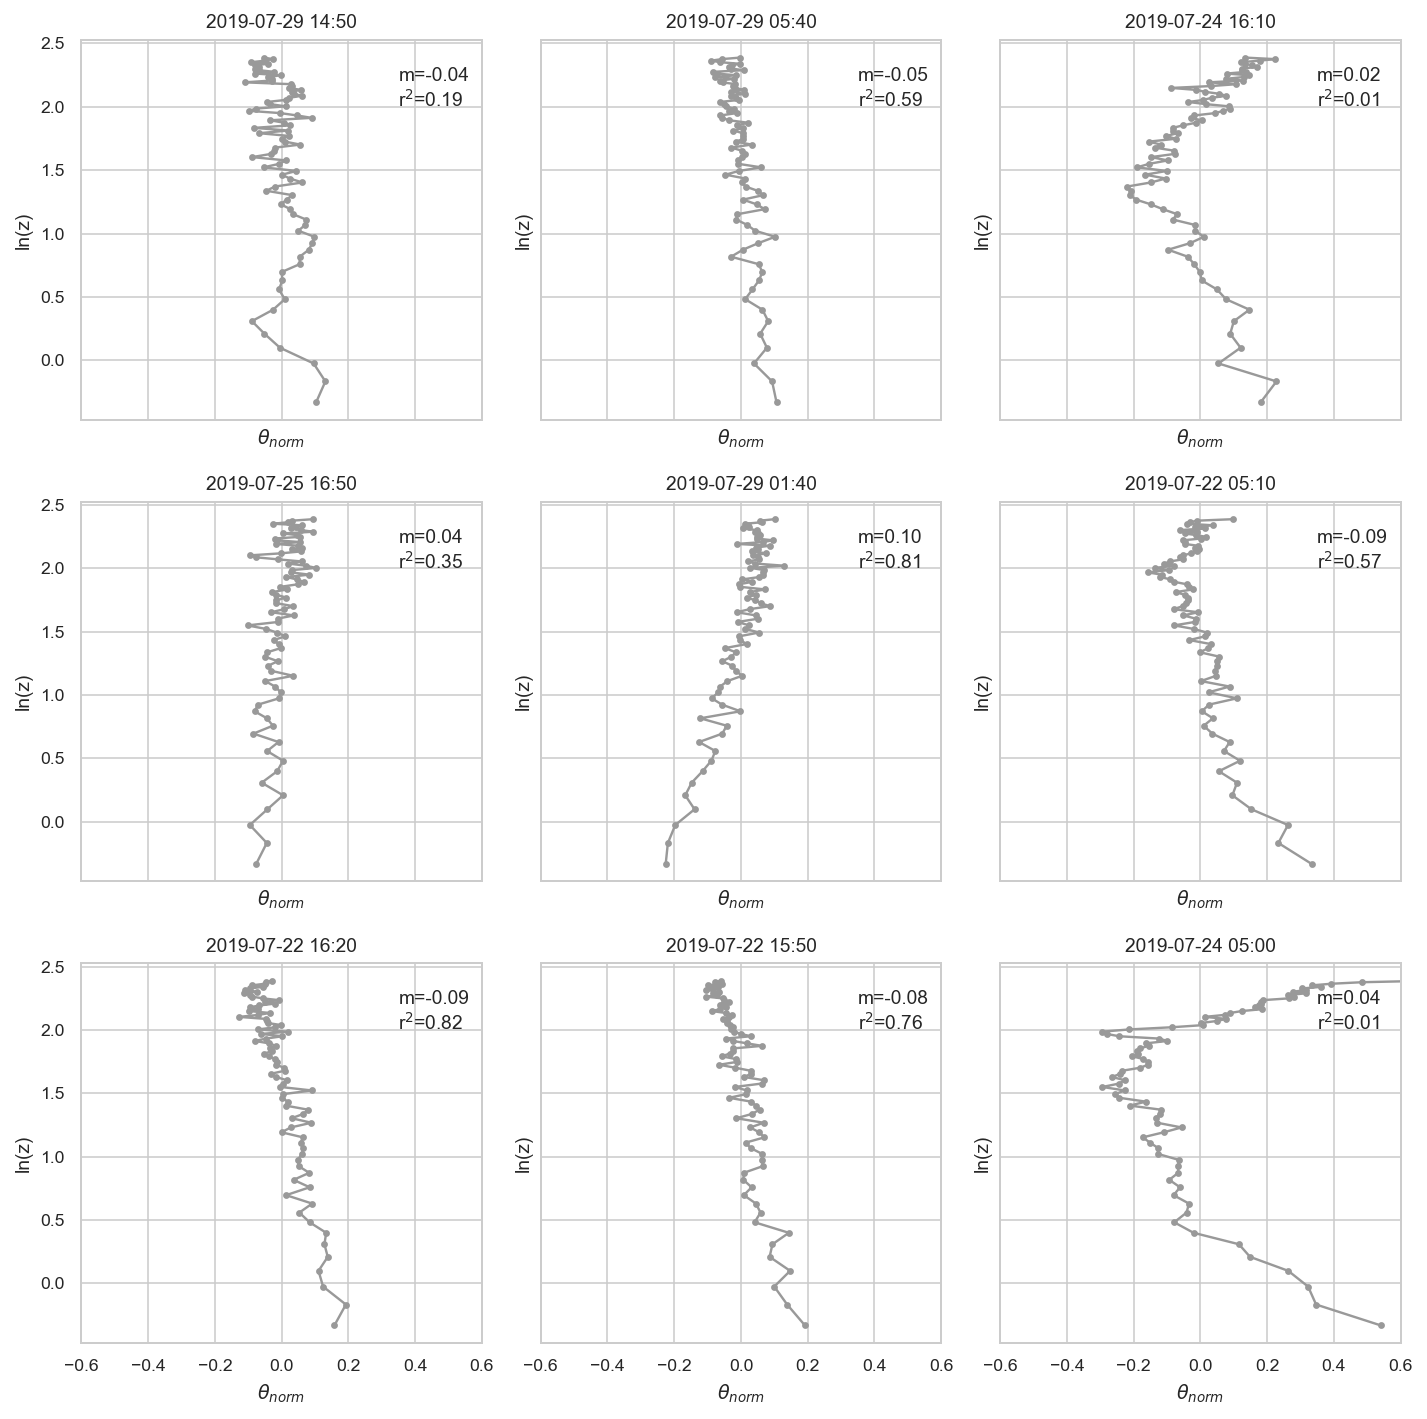

In [38]:
ind = (tower_10min.ols_m < 0.1) & (tower_10min.ols_m > -0.1)
ds = tower_10min.where(ind, drop=True)

rng = default_rng()
samp = rng.choice(len(ds.time.values), size=9, replace=False)

fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(10, 10))
axes = axes.flatten()

for ns, n in enumerate(samp):
    ax = axes[ns]
    
    dt = pd.Timestamp(ds.isel(time=n).time.values)
    ds_plot = ds.isel(time=n)
    
    ax.plot(ds_plot.theta_mean_norm, ds_plot.lnz.values, color='0.6', marker='.')
    ax.set_title(dt.strftime('%Y-%m-%d %H:%M'))
    ax.set_ylabel('ln(z)')
    ax.set_xlabel(r'$\theta_{norm}$')
    ax.set_xlim(-0.6, 0.6)
    ax.text(0.35, 2, 'm={:0.2f}\nr$^2$={:0.2f}'.format(ds_plot.ols_m.values, ds_plot.ols_r.values**2))

fig.tight_layout()

Often these "neutral" periods actually have layering present. Only some of the periods are actually neutral. Discriminating these two scenarios is of major scientific interest.

# 4. Bayesian linear regression with likelihood outlier classification

Bayesian Generalized Linear Models give well-defined parameter uncertainty and confidence intervals. As part of the GLM I can use the Hogss inlier classifier for points that are in-liers vs outliers. The implication of adequately implementing such a model means I can more robustly determine the log-linear slope, intercept, and artifacts/similarity theory violating periods, in addition to how far the sonic potential temperature is from the neutral boundary layer profile. See the above profiles for an example of why that matters. Note how there are certain obvious features that do not fit within the linear profile.

## 4.1 Relating $\frac{dT}{dz}$ to theory

The GLM can be used to directly model and test similarity theory. Here we can use:

$T(z) =  T(z=z_{0}) + \frac{\theta*}{k}\left\{\frac{\ln{z}}{\ln{z_T}} - \psi \left( \frac{\ln{z}}{\ln{L}} \right) \right\}$

where $\theta*=\frac{\overline{wT}}{u*}$, the normalized sensible heat flux, $z_T$ is the scalar roughness length scale for temperature, $L$ is the Obukhov length scale, and $\psi$ is the stability correction, and $k$ is the von Karman constant.

For neutral conditions, the second term in the brackets disappears, meaning that the slope of the GLM should be $\frac{\theta*}{k\ln{z_0}}$ and the intercept should be:

$b_{0} = T(z=z_{0}) - \frac{\theta*}{k\ln{z_T}}$

Unfortunately, in $\ln{z}$ space the intercept actually occurs at ~1m height. We can feed that directly into the model, but it somewhat limits the inference of the more interesting physical quantity, $T(z=z_T)$, directly from model parameters. Fortunately, this term is usually fairly small and can be estimated using a number of different parameterizations. Here I will use the Yang 2008 parameterization included in the Noah LSM.

All of this is to say I actually have well-informed priors for the slope and offset that can be used to inform the Bayesian GLM.

## 4.2 Model Priors


### 4.2.1. Estimate uncertainty at the 10 minute scale for the DTS data

I want to use periods that are near neutral to get a sense of the distribution. I choose neutral conditions with the linear fit, as it should allow a derivation of the distribution of points without any stability trend interfering. This is only weakly true, so some long-tail distribution is likely most appropriate for representing the distribution of DTS points.

####  Standardizing the data?

While the literature on Bayesian GLM stress the importance of standardizing the data, this comes with the cost of removing the physical meaning for the coefficients. As the physical meaning is what allows me to inform the priors, I opt to not use any standardizing. 

I need to provide uncertainty estimates on the observations. When aggregating to 10minutes I took the standard deviation for each time-space bin. However, I do not believe this is an accurate estimate of observation uncertainty, since this includes the effect of non-stationarity. The below plot shows that the standard deviation can become very high at certain times and heights, likely reflecting a real physical process that is of interest.

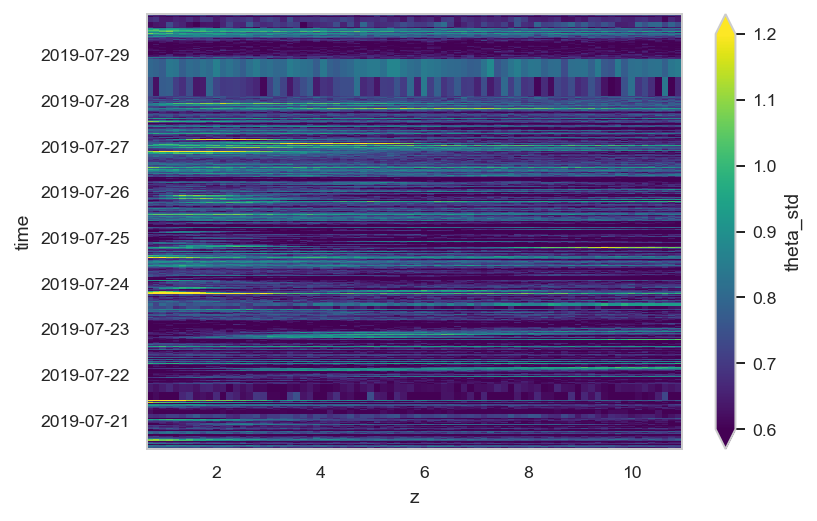

In [40]:
tower_10min.swap_dims({'xyz': 'z'}).theta_std.plot(vmin=0.6, vmax=1.2)

### 4.2.2 Model priors when enforcing stationarity

Instead let's look at a period where I can more safely assume (temporal) stationarity by using neutral conditions. The ols linear fits will inform this decision making.

To give less strict priors I will use a "neutral" cut-off of 0.1K/m instead of 0.04K/m. 

On a related note, what are the the units of the gradient when using the semilog profile? K/ln(m)?

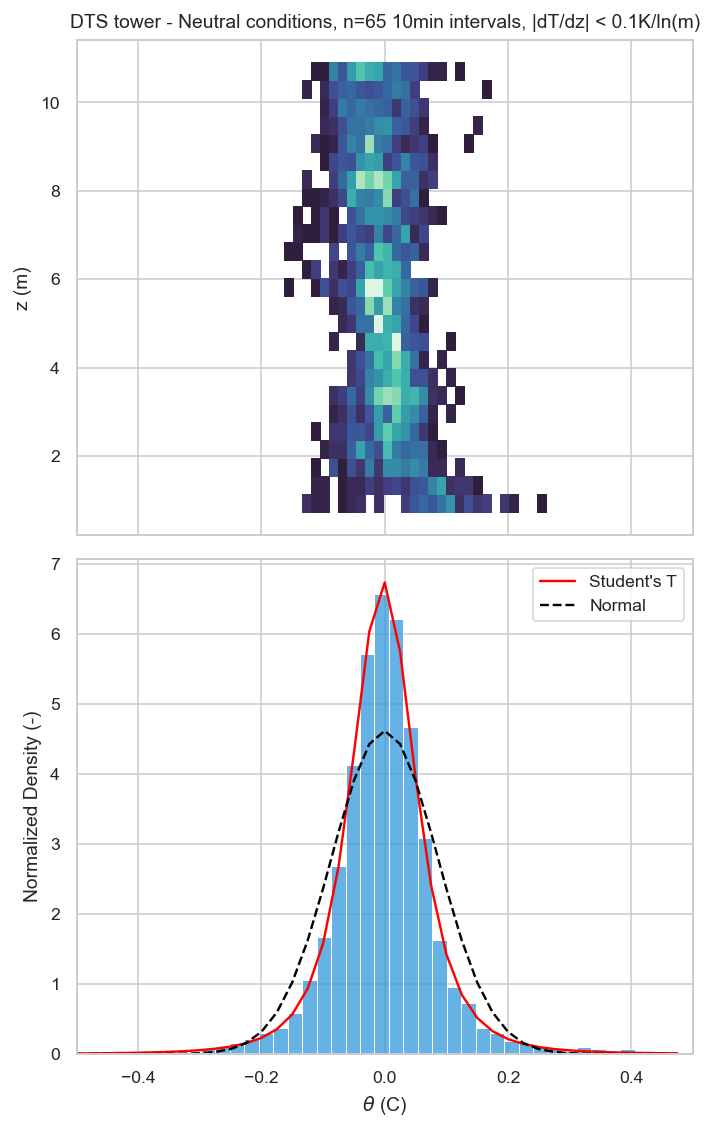

In [42]:
sns.set_context('paper')

ind = (tower_10min.ols_m > -0.1) & (tower_10min.ols_m < 0.1)
ds = tower_10min.where(ind, drop=True)

z = ds.z.values
z, _ = np.meshgrid(z, ds.time.values)
z = np.array(z)
samp = ds['theta_mean_norm'].values.flatten()

fig, axes = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
ax = axes[0]
sns.histplot(x=samp, y=z.flatten(), bins=(80, 25), pthresh=.1, cmap="mako", ax=ax)
ax.set_ylabel('z (m)')

ax = axes[1]
x = np.arange(-0.5, 0.5, 0.025)

# Student-t fit
param_studentt = scipy.stats.t.fit(samp)
pdf_fitted_studentt = scipy.stats.t.pdf(x, loc=param_studentt[1], scale=param_studentt[2], df=param_studentt[0])

# Normal gaussian
param_guass = scipy.stats.norm.fit(samp)
pdf_fitted_guass = scipy.stats.norm.pdf(x, loc=param_guass[0], scale=param_guass[1])

ax.plot(x, pdf_fitted_studentt,'r-', label='Student\'s T')
ax.plot(x, pdf_fitted_guass,'k--', label='Normal')

sns.histplot(x=ds['theta_mean_norm'].values.flatten(), bins=(50), ax=ax, stat='density')
ax.set_ylabel('Normalized Density (-)')
ax.set_xlabel(r'$\theta$ (C)')
ax.set_xlim(-0.5, 0.5)
ax.legend()
axes[0].set_title('DTS tower - Neutral conditions, n={} 10min intervals, |dT/dz| < {}K/ln(m)'.format(ind.sum().values, 0.1))
fig.tight_layout()

In [43]:
print('df={}, loc={}, scale={}'.format(param_studentt[0], param_studentt[1], param_studentt[2]))

df=3.053390435630643, loc=-0.0023708708481033312, scale=0.05457303519244836


Using the neutral data, it is pretty clear that the DTS data is better described by a Student's t-distribution and is not normally distributed. I will be informing the priors for the observational uncertainty in the Bayesian GLM using the Student's t-distribution instead of a normal distribution.

Standard deviation is much less than the value calculated for the 10 min aggregations. For comaprison I will also do a GLM using assuming a normally distributed prior. For the std in this case I'm going to go with 0.15K as my weakly informative prior.

### 4.2.3 Priors for slope and surface roughness scale for temperature

The intercept should be the surface temperature. But, first, define the data set for the linear fitting. I am selecting an interesting case in which we have two distinct sublayers.

Text(0, 0.5, '$\\theta$ (C)')

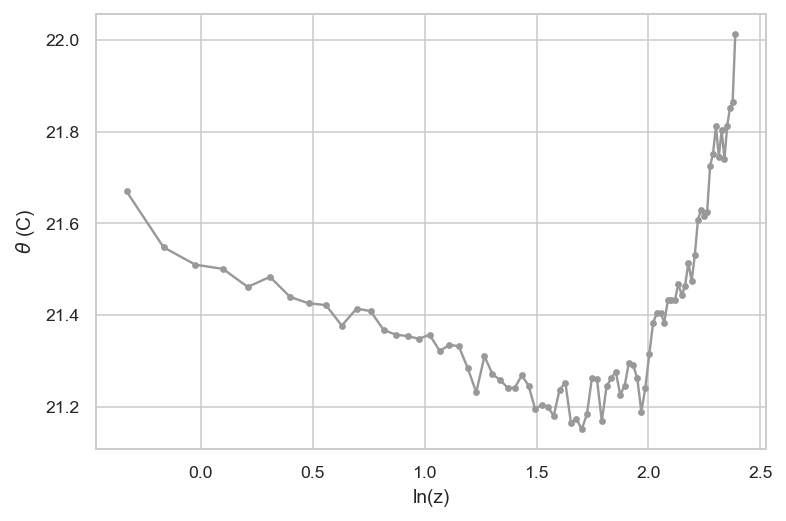

In [46]:
t_interest = pd.Timestamp('2019-07-27 04:50')

ds_bayes_GLM = tower_10min.sel(time=t_interest)
ds_sonic = sonic_10min_sub.sel(time=t_interest)

# And plot it
ds_bayes_GLM["sigma_theta"] = 0.15
plt.plot(
    ds_bayes_GLM.lnz,
    ds_bayes_GLM.theta_mean,
    color='0.6',
    marker='.')
plt.gca().set_xlabel('ln(z)')
plt.gca().set_ylabel(r'$\theta$ (C)')

#### Estimate the surface roughness length for temperature

We can use something like the below function to estimate the surface roughness length for temperature.

In [47]:
def yang_08(ustar, tstar, z0Ground, airTemp, mHeight):
    '''
    As implemented in NoahMPv1.1
    '''
    if np.max(airTemp) < 200:
        airTemp = airTemp + 273.15
    
    # Constants
    beta = 7.2  # m^(-1/2) s^(1/2) K^(-1/4)
    m = 0.5
    n = 0.25
    # Kinematic viscosity (as estimated in Andreas 1987)
    kinvisc = (1. * 10.**7. / (.9065 * airTemp - 112.7)) ** (-1.)

    z0Ground = 70 * kinvisc / ustar * np.exp(-beta * ustar**(m)
                                             * np.abs(tstar)**(n))
    z0Groundh = z0Ground
    z0Groundq = z0Ground

    # Log profiles
    dlogT = np.log(mHeight / z0Groundh)
    dlogQ = np.log(mHeight / z0Groundq)

    return (z0Groundh, z0Groundq, dlogQ, dlogT)

In [48]:
# From processing the CSAT observations using typical micrometeorological approaches
z0 = 0.366667

z0_t_est, _, _, _ = yang_08(
    ds_sonic['u*'].sel(names='1m').values,
    ds_sonic.wTs.sel(names='1m').values,
    z0,
    ds_bayes_GLM.theta_mean.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest').values,
    1.)
print(z0_t_est)

0.019491889362988107


### Compare DTS temperature profile metrics to observed turbulence properties 

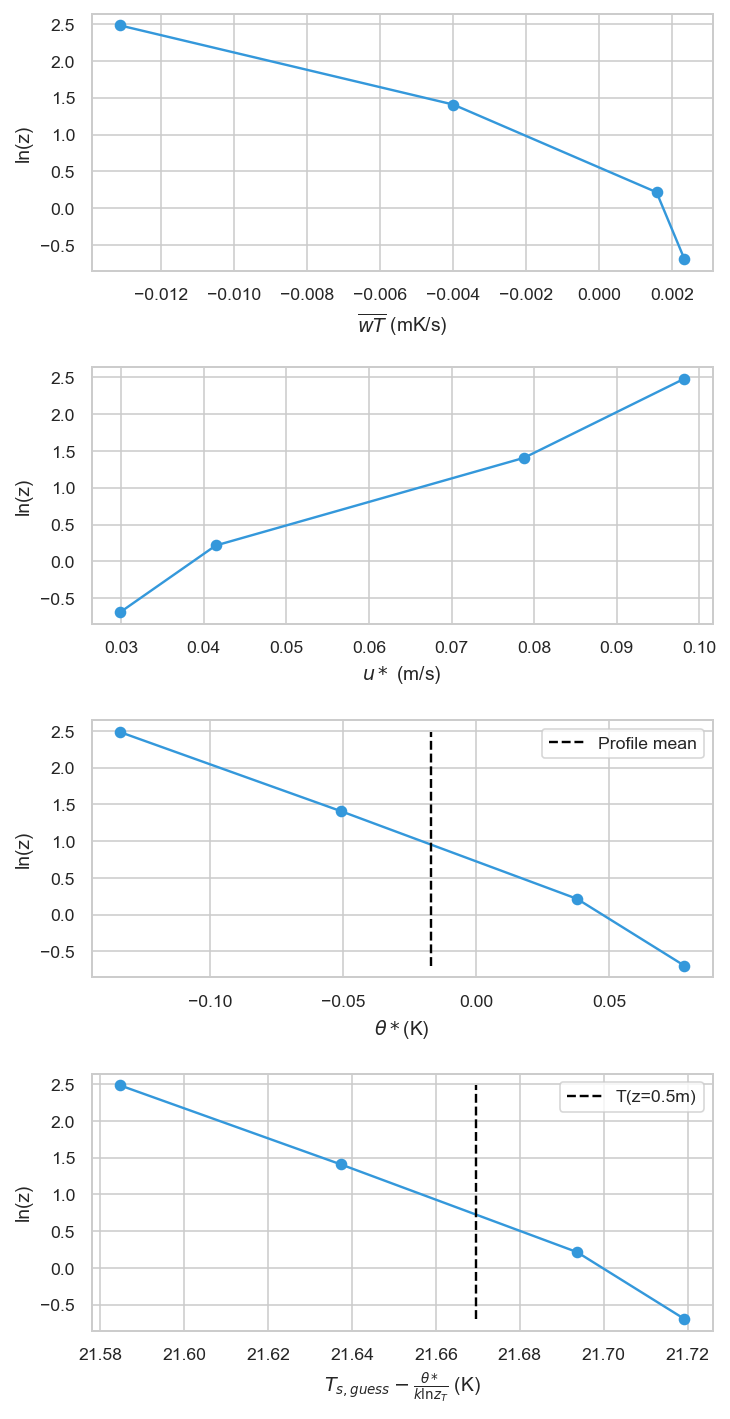

In [49]:
theta_star = (ds_sonic.wTs / ds_sonic['u*'])
theta_star_profile_avg = theta_star.mean(dim='names').values

b0_most = ds_bayes_GLM.theta_mean.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest') - theta_star / (0.4 * np.log(z0_t_est))

fig, axes = plt.subplots(4, 1, figsize=(5, 10))

ax = axes[0]
ax.plot(ds_sonic.wTs.values, np.log(ds_sonic.z.values), marker='o')
ax.set_ylabel('ln(z)')
ax.set_xlabel(r'$\overline{wT}$ (mK/s)')

ax = axes[1]
ax.plot(ds_sonic['u*'].values, np.log(ds_sonic.z.values), marker='o')
ax.set_ylabel('ln(z)')
ax.set_xlabel(r'$u*$ (m/s)')

ax = axes[2]
ax.plot(theta_star.values, np.log(ds_sonic.z.values), marker='o')
ax.plot(
    [theta_star_profile_avg, theta_star_profile_avg], 
    [np.log(0.5), np.log(12)],
    'k--',
    label='Profile mean'
)
ax.legend()
ax.set_ylabel('ln(z)')
ax.set_xlabel(r'$\theta* $(K)')

ax = axes[3]
ax.plot(b0_most.values, np.log(ds_sonic.z.values), marker='o')
ax.plot(
    [ds_bayes_GLM.theta_mean.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest'),
     ds_bayes_GLM.theta_mean.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest')], 
    [np.log(0.5), np.log(12)],
    'k--',
    label='T(z=0.5m)'
)
ax.legend()
ax.set_ylabel('ln(z)')
ax.set_xlabel(r'$T_{s, guess} - \frac{\theta*}{k \ln{z_T}}$ (K)')

fig.tight_layout()

Clearly this period is not actually neutral. The upper part of even has some real turbulence. Reassuringly, the sign inflection in the senisble heat flux roughly lines up with what the DTS suggests for the change in the stability's sign.

Consequently, the 1m CSAT as the basis for my weakly-informative priors for $\theta*$. For the intercept term I will use $T(z=0.5m)$ since the correction is so tiny.

In [52]:
theta_star = (ds_sonic.wTs / ds_sonic['u*'])
theta_star_profile_avg = theta_star.mean(dim='names').values

b0_most = ds_bayes_GLM.theta_mean.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest') - theta_star / (0.4 * np.log(z0_t_est))

b1_most = theta_star / (0.4 * np.log(z0_t_est))

b1_guess = b1_most.sel(names='1m')
b0_guess = b0_most.sel(names='1m')

print('Initial guess for the slope={:2.3f}K/ln(m)'.format(b1_guess.values))
print('Initial guess for the intercept={:2.3f}K'.format(b0_guess.values))

Initial guess for the slope=-0.024K/ln(m)
Initial guess for the intercept=21.694K


Nice, so the estimate for the initial slope is actually very close to neutral and is even within the limits I set for a neutral profile.

# 5. Running the Bayesian GLMs

## 5.1 Linear model with normal distribution priors

### Build the model

In [53]:
x = ds_bayes_GLM.lnz
y = ds_bayes_GLM.theta_mean

with pm.Model() as mdl_ols:

    # Define weakly informative Normal priors to give Ridge regression
    
    # I want the model to search for an intercept temperature close to what I can estimate
    b0 = pm.Normal("b0_intercept", mu=b0_guess.values, sigma=1)
    # I don't want the model searching for a slope far away from the initial guess
    b1 = pm.Normal("b1_slope", mu=b1_guess.values, sigma=0.5)

    # Define linear model
    y_est = b0 + b1 * x

    # Define Normal likelihood
    likelihood = pm.Normal(
        "likelihood",
        mu=y_est,
        sigma=0.15,  # From the above analysis
        observed=y.values)

### Run the model

In [54]:
with mdl_ols:
    trc_ols = pm.sample(
        tune=10000,
        draws=500,
        chains=2,
        cores=2,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 102.13:  23%|██▎       | 11699/50000 [00:02<00:06, 5848.00it/s]
Convergence achieved at 11700
Interrupted at 11,699 [23%]: Average Loss = 981.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b1_slope, b0_intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:15<00:00, 1343.65draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


### Visualize the model results

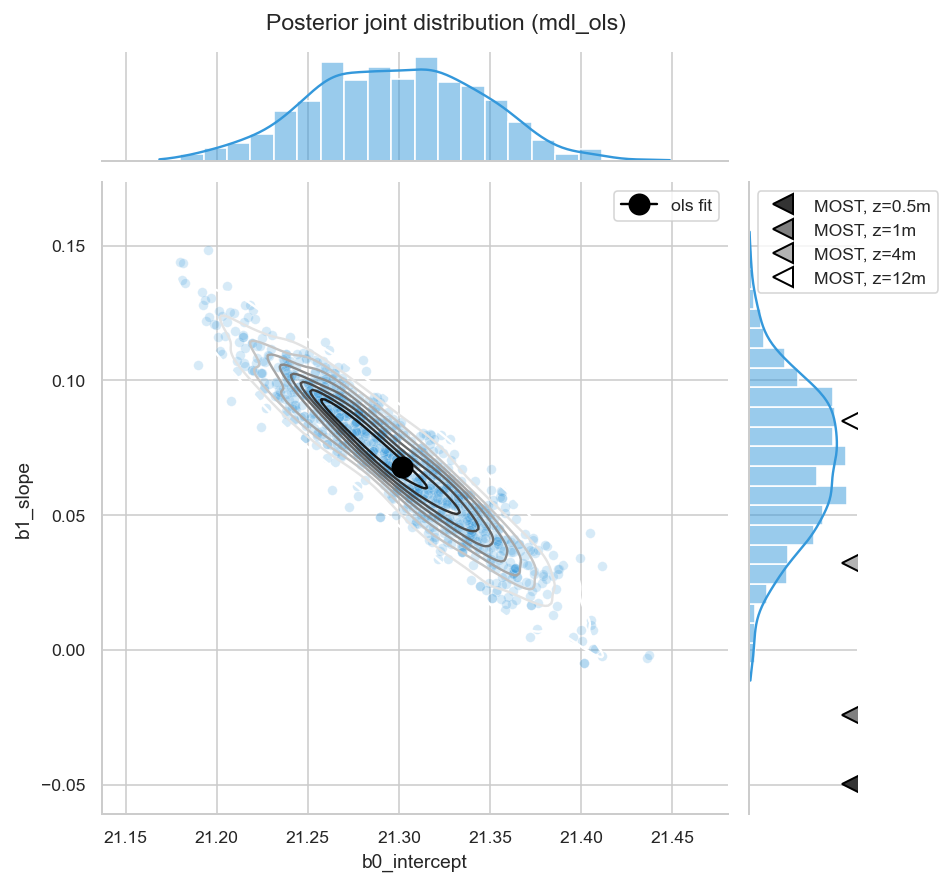

In [55]:
df_trc_ols = pm.trace_to_dataframe(trc_ols)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_ols,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
    color=flatui[0],
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (mdl_ols)", y=1.02)

csat_colors = ['0.2', '0.5', '0.7', '1']
gd.ax_joint.plot(
    ds_bayes_GLM['ols_b'].values,
    ds_bayes_GLM["ols_m"].values,
    marker='o',
    color='k',
    label='ols fit',
    markersize=10
)

_, xloc = gd.ax_marg_y.get_xlim()

for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend()
gd.ax_marg_y.legend()

In [56]:
print('OLS slope:')
print(ds_bayes_GLM["ols_m"].values)

OLS slope:
0.06774970640844576


So here we can see that the slope uncertainty is actually non-negligible and that the mean slope is not quite zero, which is not too far from what I estimated using the typical ordinary least squares fitting approach.

## 5.2 Same thing but using the T-student likelihood distribution instead of a normal distribution

### Build the GLM

In [57]:
x = ds_bayes_GLM.lnz
y = ds_bayes_GLM.theta_mean

with pm.Model() as mdl_studentt:

    # define weakly informative Normal priors to give Ridge regression
    # I want the model to search for an intercept temperature close to what I can estimate
    b0 = pm.Normal("b0_intercept", mu=b0_guess.values, sigma=1)
    # I don't want the model searching for a slope far away from the initial guess
    b1 = pm.Normal("b1_slope", mu=b1_guess.values, sigma=0.5)
    # define linear model
    y_est = b0 + b1 * x

    # define prior for StudentT degrees of freedom
    # The student t I fit above used a Gamma dist. for degrees of freedom:
    # it's continuous and has support x ∈ (0, inf)
    # I can use the dof defined previously as a starting point.
    # There are two ways to define the distribution:
    #    1) alpha and beta parameters
    #    2) a mean and standard deviation
    # I will use option 2 since I estimated the dof directly, which should
    # correspond to the mean of the distribution.
    nu = pm.Gamma(
        "nu",
        mu=param_studentt[0],
        sigma=2)
   
    # define Student T likelihood
    # The "scale" parameter is given from the above analysis
    likelihood = pm.StudentT(
        "likelihood",
        mu=y_est,
        sigma=param_studentt[2],
        nu=nu,
        observed=y.values)

### Run the GLM

In [58]:
with mdl_studentt:
    trc_studentt = pm.sample(
        tune=5000,
        draws=500,
        chains=2,
        cores=2,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 46.346:  26%|██▌       | 12999/50000 [00:03<00:09, 3869.12it/s]
Convergence achieved at 13000
Interrupted at 12,999 [25%]: Average Loss = 190.37
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:05<00:00, 1977.39draws/s]


### Visualize model results

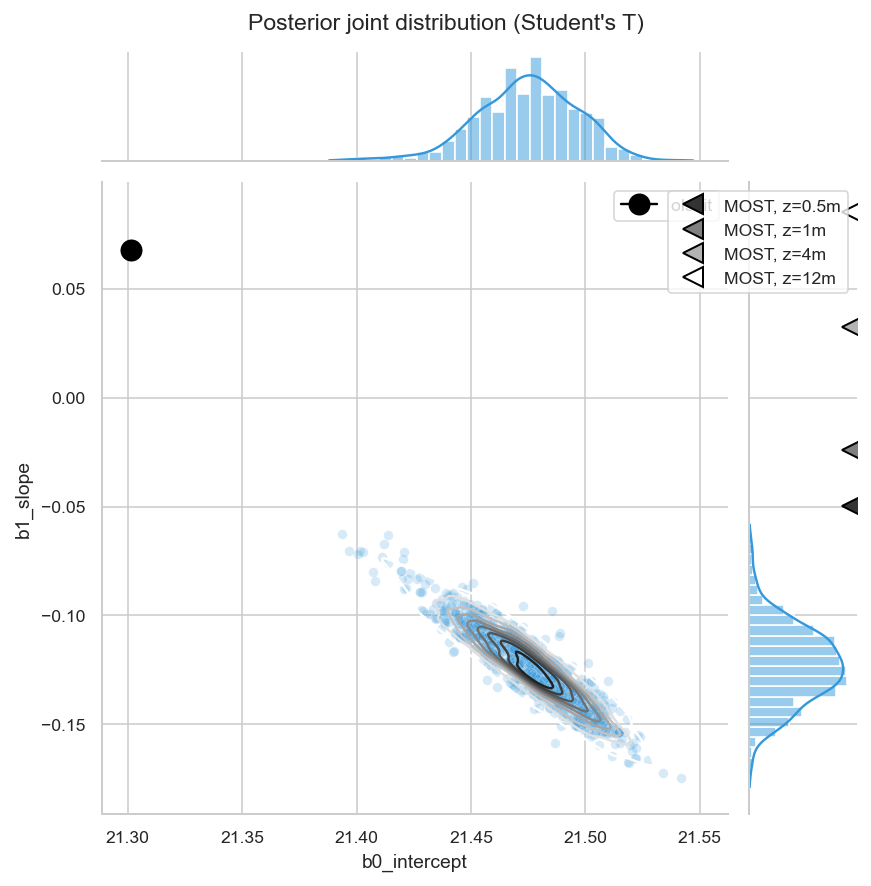

In [59]:
df_trc_studentt = pm.trace_to_dataframe(trc_studentt)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_studentt,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
    color=flatui[0],
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (Student's T)", y=1.02)

csat_colors = ['0.2', '0.5', '0.7', '1']
gd.ax_joint.plot(
    ds_bayes_GLM['ols_b'].values,
    ds_bayes_GLM["ols_m"].values,
    marker='o',
    color='k',
    label='ols fit',
    markersize=10
)

_, xloc = gd.ax_marg_y.get_xlim()

for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend()
gd.ax_marg_y.legend()

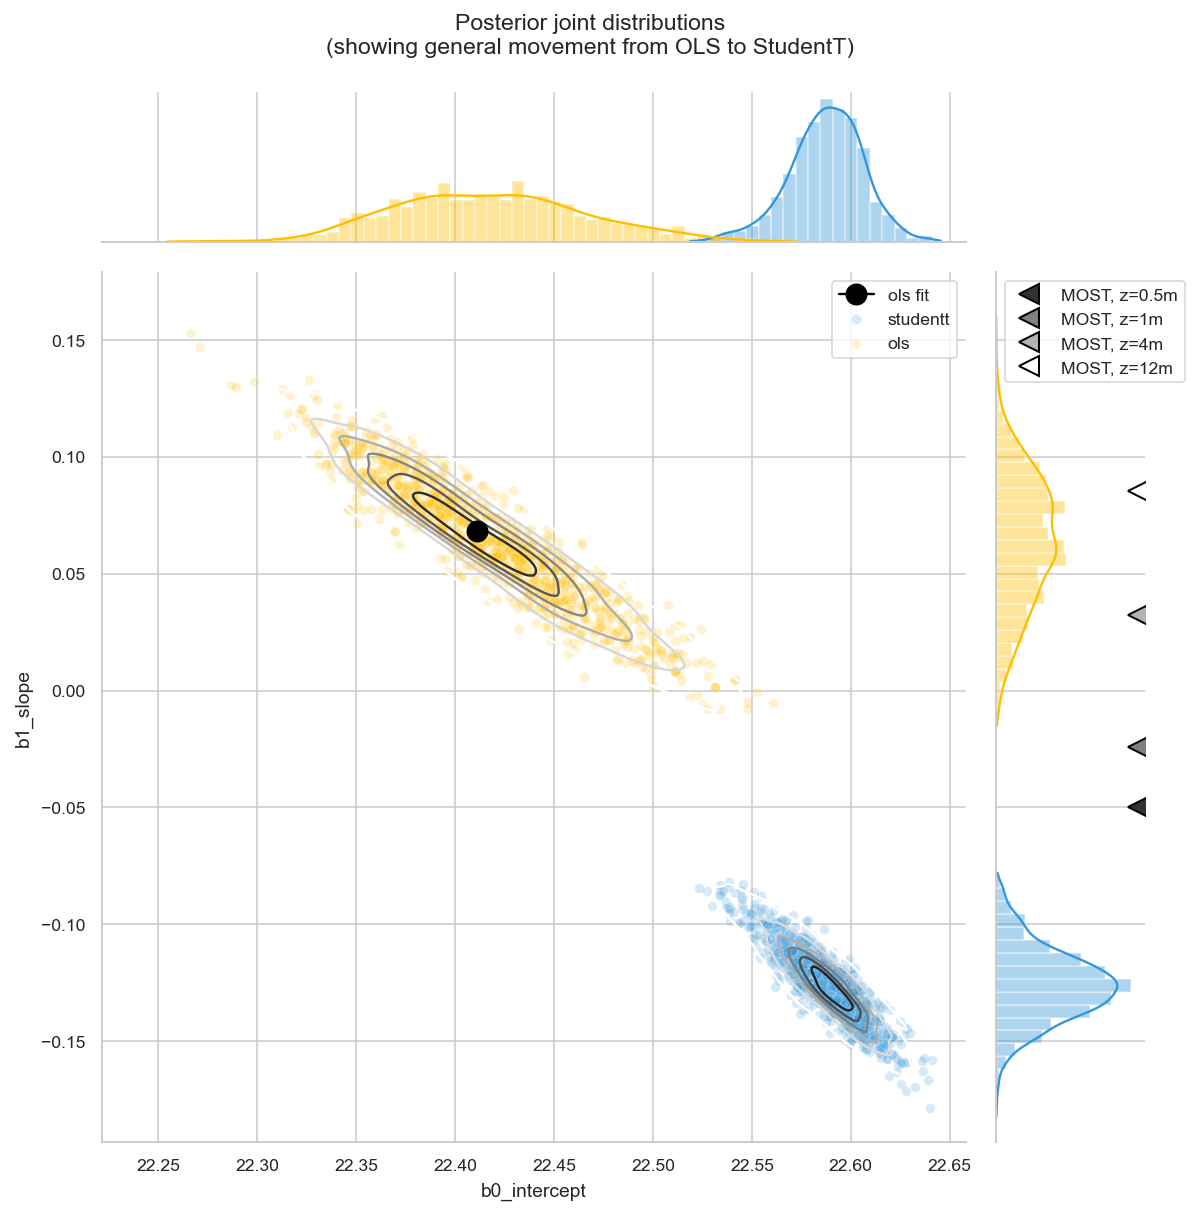

In [78]:
fts = ["b0_intercept", "b1_slope"]
df_trc = pd.concat((df_trc_ols[fts], df_trc_studentt[fts]), sort=False)
df_trc["model"] = pd.Categorical(
    np.repeat(["ols", "studentt"], len(df_trc_ols)),
    categories=["studentt", "ols"],
    ordered=True,
)

gd = sns.JointGrid(x="b0_intercept", y="b1_slope", data=df_trc, height=8)
_ = gd.fig.suptitle(
    ("Posterior joint distributions" + "\n(showing general movement from OLS to StudentT)"),
    y=1.05,
)

_, x_bin_edges = np.histogram(df_trc["b0_intercept"], 60)
_, y_bin_edges = np.histogram(df_trc["b1_slope"], 60)

kde_kws = dict(zorder=2, n_levels=7, cmap="gray_r")
dist_kws = dict(kde_kws=dict(cut=1), axlabel=False)

for num, (idx, grp) in enumerate(df_trc.groupby("model")):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # cheap hack to ignore warnings from plot empty categorical grp

        _ = sns.scatterplot(
            grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, alpha=0.2, label=idx, color=flatui[num]
        )
        _ = sns.kdeplot(grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, color=flatui[num], **kde_kws)
        _ = sns.distplot(
            grp["b0_intercept"], bins=x_bin_edges, ax=gd.ax_marg_x, color=flatui[num], **dist_kws)
        _ = sns.distplot(
            grp["b1_slope"], vertical=True, bins=y_bin_edges, ax=gd.ax_marg_y, color=flatui[num], **dist_kws
        )

csat_colors = ['0.2', '0.5', '0.7', '1']
gd.ax_joint.plot(
    ds_bayes_GLM['ols_b'].values,
    ds_bayes_GLM["ols_m"].values,
    marker='o',
    color='k',
    label='ols fit',
    markersize=10
)

_, xloc = gd.ax_marg_y.get_xlim()

for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend()
gd.ax_marg_y.legend()


The GLM using a prior estimate as a Student's distribution provides a tighter distribution of slope parameters than the ordinary least squares fit, which assumes a normally distributed variable. Further, there is a sign agreement between the sonic anemometers in the bottom of the profile and the slope.

### 5.3 Hoggs Inlier vs Outlier classifier

I can take this even further by adding a classifier that either excludes points (outliers) or includes points (inliers). This should help with identifying where/when artifacts occur. I am explicitly stealing the code from here: https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html

Additional references:

The original pdf:
https://cosmo.nyu.edu/hogg/research/2010/08/17/straightline.pdf

A paper that uses the improved fitting from excluding Bayes derived outliers:
https://academic.oup.com/mnras/article/442/4/3380/1355552

The very broad brushstroke of the method is that it builds a liklihood model based on a Bernoulli distribution. Points are more likely to be outliers when the uncertainty in the linear fitting paramters decreases.

_Important note_: I am abusing the inlier classifier. The reality is that there are often physical sublayers present and that we want to model those explicitly including the height of the slope change, indicating the transition between sublayers. For this purpose something like a Bayes Gaussian Process changepoint modeling would be more appropriate. This is future work. 

### Build the model

In [60]:
x = ds_bayes_GLM.lnz
y = ds_bayes_GLM.theta_mean

with pm.Model() as mdl_hogg:

    # state input data as Theano shared vars
    tsv_x = pm.Data("tsv_x", x.values)  # (n, )
    tsv_y = pm.Data("tsv_y", y.values)  # (n, )
    tsv_sigma_y = pm.Data("tsv_sigma_y", param_studentt[2])  # (1, )

    # weakly informative Normal priors (L2 ridge reg) for inliers
    # I want the model to search for an intercept temperature close to what I can estimate
    b0 = pm.Normal("b0_intercept", mu=b0_guess.values, sigma=0.5, testval=pm.floatX(0.0))
    # I don't want the model searching for a slope far away from the initial guess
    b1 = pm.Normal("b1_slope", mu=b1_guess.values, sigma=0.5, testval=pm.floatX(1.0))

    # linear model for mean for inliers
    y_est_in = b0 + b1 * tsv_x  # (n, )

    # very weakly informative mean for all outliers
    y_est_out = pm.Normal("y_est_out", mu=0, sigma=0.6, testval=pm.floatX(0.0))  # (1, )

    # very weakly informative prior for additional variance for outliers
    # The physical interpretation here is that points impacted by artifacts may have
    # a different variance than points impacted by just the atmosphere
    sigma_y_out = pm.HalfNormal("sigma_y_out", sigma=1, testval=pm.floatX(1.0))  # (1, )

    # create in/outlier distributions to get a logp evaluated on the observed y
    # this is not strictly a pymc3 likelihood, but behaves like one when we
    # evaluate it within a Potential (which is minimised)
    inlier_logp = pm.Normal.dist(mu=y_est_in, sigma=tsv_sigma_y).logp(tsv_y)

    outlier_logp = pm.Normal.dist(mu=y_est_out, sigma=tsv_sigma_y + sigma_y_out).logp(tsv_y)

    # frac_outliers only needs to span [0, .5]
    # testval for is_outlier initialised in order to create class asymmetry
    frac_outliers = pm.Uniform("frac_outliers", lower=0.0, upper=0.5)
    is_outlier = pm.Bernoulli(
        "is_outlier",
        p=frac_outliers,
        shape=tsv_x.eval().shape[0],
        testval=(np.random.rand(tsv_x.eval().shape[0]) < 0.4) * 1,
    )  # (n, )

    # non-sampled Potential evaluates the Normal.dist.logp's
    potential = pm.Potential(
        "obs",
        ((1 - is_outlier) * inlier_logp).sum() + (is_outlier * outlier_logp).sum(),
    )

### Run the model

In [61]:
with mdl_hogg:
    trc_hogg = pm.sample(
        tune=5000,
        draws=500,
        chains=2,
        cores=2,
        init="jitter+adapt_diag",
        nuts={"target_accept": 0.9},
        progressbar=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [frac_outliers, sigma_y_out, y_est_out, b1_slope, b0_intercept]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:27<00:00, 407.25draws/s]


### Visualize the posterior distribution

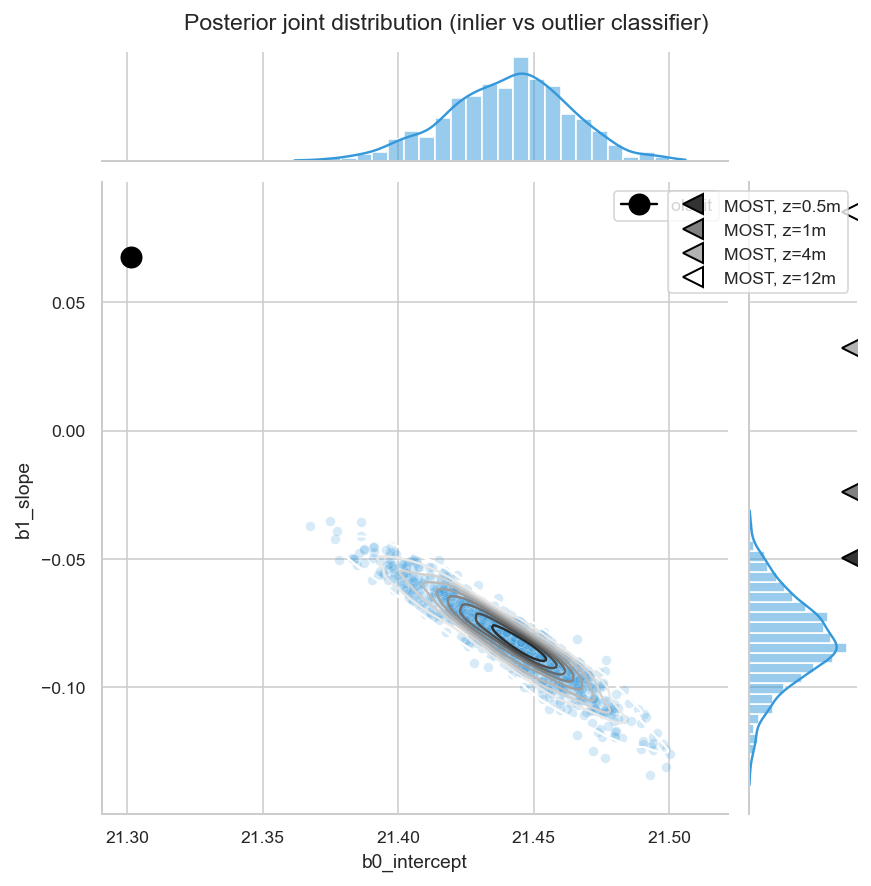

In [62]:
df_trc_hogg = pm.trace_to_dataframe(trc_hogg)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_hogg,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
    color=flatui[0],
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (inlier vs outlier classifier)", y=1.02)

csat_colors = ['0.2', '0.5', '0.7', '1']
gd.ax_joint.plot(
    ds_bayes_GLM['ols_b'].values,
    ds_bayes_GLM["ols_m"].values,
    marker='o',
    color='k',
    label='ols fit',
    markersize=10
)

_, xloc = gd.ax_marg_y.get_xlim()

for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend()
gd.ax_marg_y.legend()

### Visualize the inlier/outlier probability

Text(0.5, 1.04, 'For each datapoint, distribution of outlier classification\n over n=11000 samples')

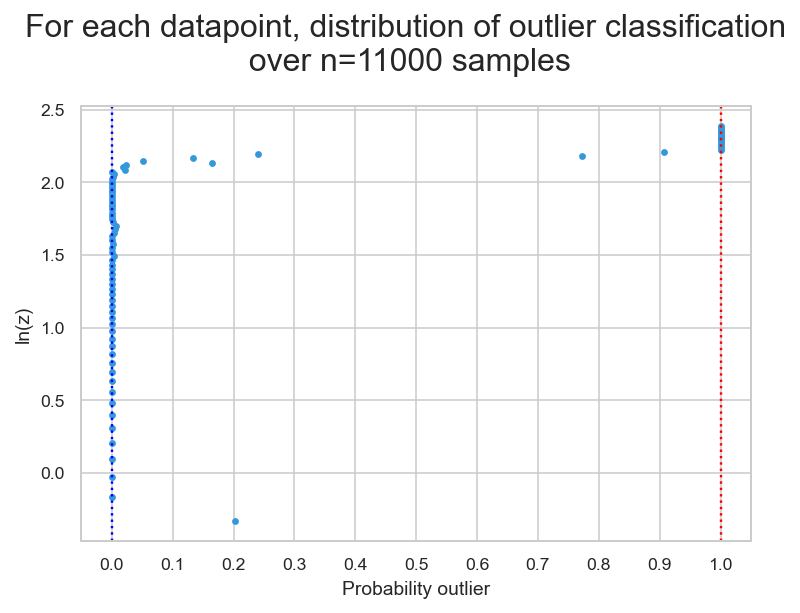

In [63]:
df_outlier_results = pd.DataFrame.from_records(trc_hogg["is_outlier"], columns=ds.lnz.values)
dfm_outlier_results = pd.melt(df_outlier_results, var_name="datapoint_id", value_name="is_outlier")

fig, ax = plt.subplots(1, 1)

ax.plot(df_outlier_results.mean(), df_outlier_results.columns, marker='.', linestyle='None')
ax.set(xlim=(-0.05, 1.05), xticks=np.arange(0, 1.1, 0.1))
ax.axvline(x=0, color="b", linestyle=":")
ax.axvline(x=1, color="r", linestyle=":")
ax.set_ylabel('ln(z)')
ax.set_xlabel('Probability outlier')
fig.suptitle(
    ("For each datapoint, distribution of outlier classification\n over n=11000 samples"),
    y=1.04,
    fontsize=16,
)

In [64]:
cutoff = 0.05
ds_bayes_GLM.coords["classed_as_outlier"] = (('xyz'), np.quantile(trc_hogg["is_outlier"], cutoff, axis=0) == 1)
print('Number of Outliers={}'.format(ds_bayes_GLM["classed_as_outlier"].sum().values))

Number of Outliers=14


## 5.4 Compare all three Bayes GLM

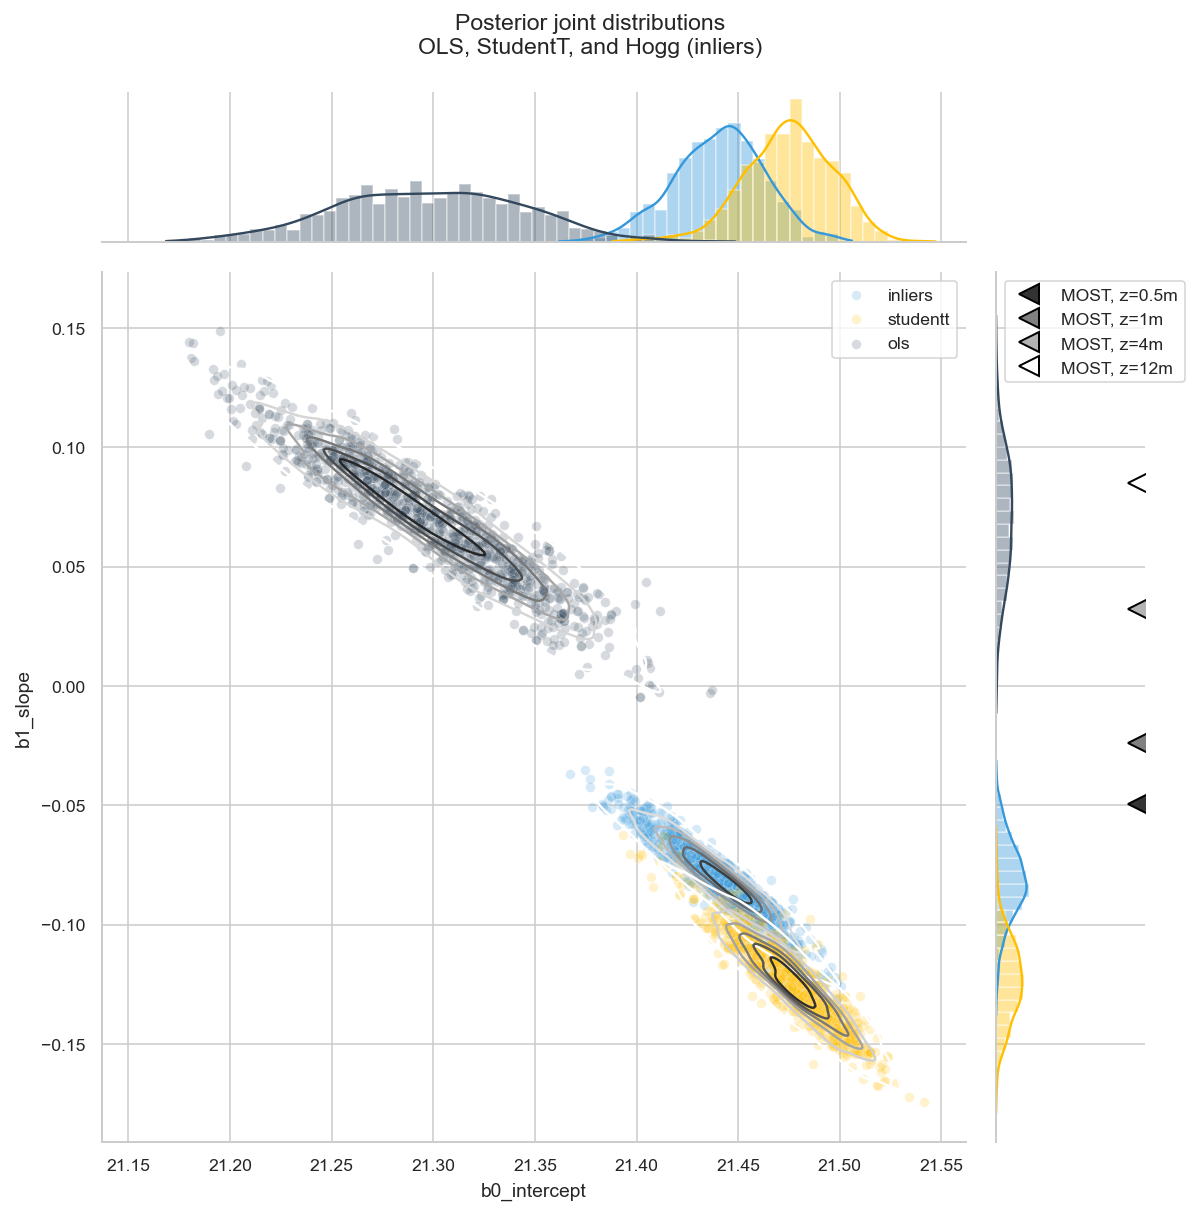

In [65]:
fts = ["b0_intercept", "b1_slope"]
df_trc = pd.concat((df_trc_ols[fts], df_trc_studentt[fts], df_trc_hogg), sort=False)
df_trc["model"] = pd.Categorical(
    np.repeat(["ols", "studentt", "inliers"], len(df_trc_ols)),
    categories=["inliers", "studentt", "ols"],
    ordered=True,
)

gd = sns.JointGrid(x="b0_intercept", y="b1_slope", data=df_trc, height=8)
_ = gd.fig.suptitle(
    ("Posterior joint distributions" + "\nOLS, StudentT, and Hogg (inliers)"), y=1.05
)

_, x_bin_edges = np.histogram(df_trc["b0_intercept"], 60)
_, y_bin_edges = np.histogram(df_trc["b1_slope"], 60)

kde_kws = dict(zorder=2, n_levels=7, cmap="gray_r")
dist_kws = dict(kde_kws=dict(cut=1), axlabel=False)

for num, (idx, grp) in enumerate(df_trc.groupby("model")):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        _ = sns.scatterplot(
            grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, alpha=0.2, label=idx, color=flatui[num]
        )
        _ = sns.kdeplot(grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, color=flatui[num], **kde_kws)
        _ = sns.distplot(
            grp["b0_intercept"], bins=x_bin_edges, ax=gd.ax_marg_x, color=flatui[num], **dist_kws)
        _ = sns.distplot(
            grp["b1_slope"], vertical=True, bins=y_bin_edges, ax=gd.ax_marg_y, color=flatui[num], **dist_kws
        )

for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend()
gd.ax_marg_y.legend()

#### Observations

Oh this is really cool! We have a much better estimate of the similarity theory values for temperature now.

The student's t-distribution prior and the Hoggs Inlier models both "de-weight" the upper part of the profile that has a different slope. As mentioned above, this is more abusing the Bayes GLM than modeling the physical process of interest. Regardless, it is a more robust estimate of the stability ($\frac{dT}{d\ln(z)}$) than the standard ols.

### Visualize the actual distribution of linear fits

Text(0.5, 1.04, 'Tower DTS with posterior predictive fit for 3 models: \n OLS, StudentT and inlier/outlier')

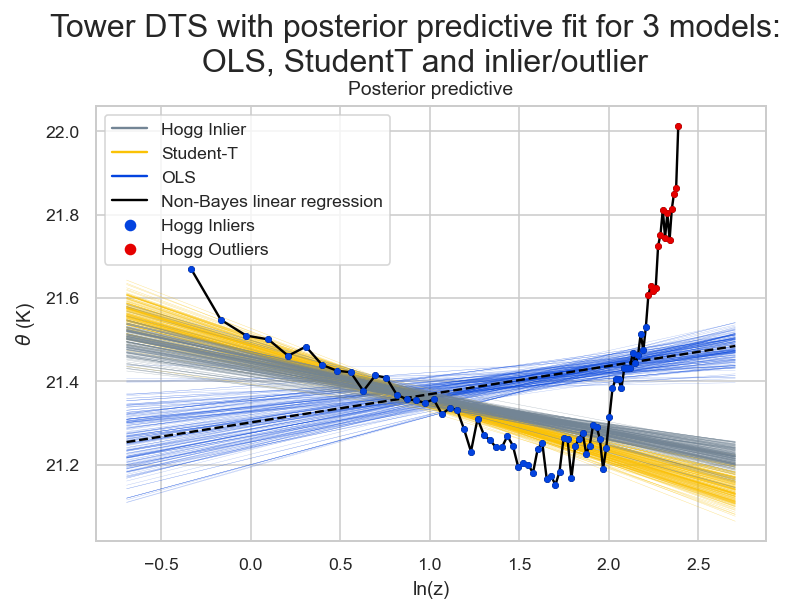

In [66]:
lnz_eval = np.arange(np.log(0.5), np.log(15), 0.01)

fig, ax = plt.subplots(1, 1)

# plot the 3 model (inlier) posterior distributions
lm = lambda x, s: s["b0_intercept"] + s["b1_slope"] * x

pm.plot_posterior_predictive_glm(
    trc_ols,
    lm=lm,
    eval=lnz_eval,
    samples=200,
    color='xkcd:blue',
    alpha=0.3,
)

pm.plot_posterior_predictive_glm(
    trc_studentt,
    lm=lm,
    eval=lnz_eval,
    samples=200,
    color='xkcd:goldenrod',
    alpha=0.5,
)

pm.plot_posterior_predictive_glm(
    trc_hogg,
    lm=lm,
    eval=lnz_eval,
    samples=200,
    color='xkcd:steel',
    alpha=0.5,
)

ax.plot(
    lnz_eval,
    ds_bayes_GLM['ols_m'].values * lnz_eval + ds_bayes_GLM['ols_b'].values,
    'k--',
)

ax.plot(
    ds_bayes_GLM.lnz.values,
    ds_bayes_GLM.theta_mean,
    color='k',
    marker='.'
)

ax.plot(
    ds_bayes_GLM.lnz.values,
    ds_bayes_GLM.theta_mean.where(ds_bayes_GLM.classed_as_outlier == 0),
    color='xkcd:blue',
    marker='.',
    linestyle='None',
)

ax.plot(
    ds_bayes_GLM.lnz.values,
    ds_bayes_GLM.theta_mean.where(ds_bayes_GLM.classed_as_outlier == 1),
    color='xkcd:red',
    marker='.',
    linestyle='None',
)



line_legend = [
        Line2D([0], [0], color='xkcd:steel', label="Hogg Inlier"),
        Line2D([0], [0], color='xkcd:goldenrod', label="Student-T"),
        Line2D([0], [0], color='xkcd:blue', label="OLS"),
        Line2D([0], [0], color='k', label="Non-Bayes linear regression"),
        Line2D([0], [0], marker='o', color='xkcd:blue', label='Hogg Inliers', linestyle='None'),
        Line2D([0], [0], marker='o', color='xkcd:red', label='Hogg Outliers', linestyle='None'),
]
ax.legend(handles=line_legend)
ax.set_ylabel(r'$\theta$ (K)')
ax.set_xlabel('ln(z)')

# create xlims ylims for plotting
fig.suptitle(
    (
        "Tower DTS with posterior predictive fit for 3 models: \n OLS, StudentT and inlier/outlier"
    ),
    y=1.04,
    fontsize=16,
)

Clearly the ability to "choose" to model only one part of the profile (Bayes student's t and Hoggs) instead of the entire profile (ols) gives a much better representation of the stability for the majority of the profile.

# 6. Create a time series of a more robustly estimated temperature gradient

After all of that, let's wrap up these estimates for the entire field campagin.

The Hoggs inlier method is a bit sensitive to the starting priors and takes much longer to run. So to estimate stability for the entire campaign, I will instead use the Student's t-distribution priors and the 1.25m height CSAT derived quantities as initial values.

In [153]:
# Only run this when I have 12 hours to spare
GLM_studentt
if GLM_studentt:
    draws = np.arange(0, 1000)
    tower_10min.coords['draws'] = draws
    tower_10min['b0_intercept'] = (('time', 'draws'), np.zeros((len(tower_10min.time), 1000)))
    tower_10min['b1_slope'] = (('time', 'draws'), np.zeros((len(tower_10min.time), 1000)))

    for nt, t in enumerate(tower_10min.time):
        print(pd.Timestamp(t.values))

        # Data for this interval
        ds_sonic = sonic_10min_sub.sel(time=t)
        ds_glm_t = tower_10min.sel(time=t)
        x = ds_glm_t.lnz
        y = ds_glm_t.theta_mean

        # Estimate priors
        z0_t_est, _, _, _ = yang_08(
            ds_sonic['u*'].sel(names='1m').values,
            ds_sonic.wTs.sel(names='1m').values,
            z0,
            y.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest').values,
            1.)

        theta_star = (ds_sonic.wTs / ds_sonic['u*'])
        theta_star_profile_avg = theta_star.mean(dim='names').values

        b0_most = y.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest')
        b1_most = theta_star / (0.4 * np.log(z0_t_est))

        b1_guess = b1_most.sel(names='1m')
        b0_guess = b0_most

        with pm.Model() as mdl_studentt:

            # define weakly informative Normal priors to give Ridge regression
            # I want the model to search for an intercept temperature close to what I can estimate
            b0 = pm.Normal("b0_intercept", mu=b0_guess.values, sigma=3)
            # I don't want the model searching for a slope far away from the initial guess
            b1 = pm.Normal("b1_slope", mu=b1_guess.values, sigma=3)
            # define linear model
            y_est = b0 + b1 * x

            # define prior for StudentT degrees of freedom
            # The student t I fit above used a Gamma dist. for degrees of freedom:
            # it's continuous and has support x ∈ (0, inf)
            # I can use the dof defined previously as a starting point.
            # There are two ways to define the distribution:
            #    1) alpha and beta parameters
            #    2) a mean and standard deviation
            # I will use option 2 since I estimated the dof directly, which should
            # correspond to the mean of the distribution.
            nu = pm.Gamma(
                "nu",
                mu=param_studentt[0],
                sigma=2)

            # define Student T likelihood
            # The "scale" parameter is given from the above analysis
            likelihood = pm.StudentT(
                "likelihood",
                mu=y_est,
                sigma=param_studentt[2],
                nu=nu,
                observed=y.values)

            trc_studentt = pm.sample(
                tune=5000,
                draws=500,
                chains=2,
                cores=2,
                init="advi+adapt_diag",
                n_init=50000,
                progressbar=False,
            )

            df_out = pm.trace_to_dataframe(trc_studentt)
            df_out.index.rename('draws', inplace=True)

            tower_10min['b0_intercept'].loc[dict(time=t)] = df_out['b0_intercept']
            tower_10min['b1_slope'].loc[dict(time=t)] = df_out['b1_slope']

    os.chdir(os.path.join(dir_pre, 'love_dts', 'bayes_glm'))
    tower_10min.to_netcdf('tower_10min_bayes_glm.nc')

2019-07-20 09:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 224.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.902929168664566, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 09:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12800
Interrupted at 12,799 [25%]: Average Loss = 229.44
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.


2019-07-20 09:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 129.57
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-20 09:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21500
Interrupted at 21,499 [42%]: Average Loss = 146.98
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.693840624071722, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-20 09:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13100
Interrupted at 13,099 [26%]: Average Loss = 251.06
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-20 09:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11500
Interrupted at 11,499 [22%]: Average Loss = 243.1
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.1670729318374532, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-20 10:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12800
Interrupted at 12,799 [25%]: Average Loss = 228.96
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-20 10:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 127.47
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-20 10:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12200
Interrupted at 12,199 [24%]: Average Loss = 240.11
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-20 10:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 116.54
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 10:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11800
Interrupted at 11,799 [23%]: Average Loss = 254.61
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8798722089309157, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-20 10:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 133.24
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-20 11:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14400
Interrupted at 14,399 [28%]: Average Loss = 233.22
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.9046537005900439, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6276893895684065, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-20 11:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21100
Interrupted at 21,099 [42%]: Average Loss = 162.7
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-20 11:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 111.65
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6539251410750478, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-20 11:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 77.926
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7096997314655445, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 11:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12900
Interrupted at 12,899 [25%]: Average Loss = 240.92
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-20 11:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12100
Interrupted at 12,099 [24%]: Average Loss = 263.73
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.7078572759774385, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 12:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14300
Interrupted at 14,299 [28%]: Average Loss = 222.71
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8906357091277936, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 12:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 127.9
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-20 12:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12800
Interrupted at 12,799 [25%]: Average Loss = 244.38
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-20 12:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 96.831
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.468902391781287, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-20 12:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 105.27
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8973390529659796, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 12:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13500
Interrupted at 13,499 [26%]: Average Loss = 215.93
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9076965156265528, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 13:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12500
Interrupted at 12,499 [24%]: Average Loss = 233.21
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-20 13:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25700
Interrupted at 25,699 [51%]: Average Loss = 91.169
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 13:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 103.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.5149525167022577, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-20 13:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13500
Interrupted at 13,499 [26%]: Average Loss = 228.49
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-20 13:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12800
Interrupted at 12,799 [25%]: Average Loss = 232.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-20 13:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 95.63
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-20 14:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 103.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-20 14:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 115.84
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 14:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22300
Interrupted at 22,299 [44%]: Average Loss = 134.92
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-20 14:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 93.172
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7132530800632769, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 14:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 100.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 14:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24800
Interrupted at 24,799 [49%]: Average Loss = 111.38
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.39261999833238803, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-20 15:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 102.36
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-20 15:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 101.74
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.7103736884421017, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-20 15:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11100
Interrupted at 11,099 [22%]: Average Loss = 226.1
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6961667198065555, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 15:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 82.56
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 15:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 92.383
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9001420508864844, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 15:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 89.159
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 16:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 81.488
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8993194105150103, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 16:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 77.52
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.7174113118686787, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 16:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 72.11
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 16:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 75.7
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8870023674724051, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 16:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 78.929
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 16:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 75.22
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6509065589994705, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-20 17:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 79.634
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8999908272599914, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 17:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10500
Interrupted at 10,499 [20%]: Average Loss = 234.76
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 17:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 80.456
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6453889560048204, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 17:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22900
Interrupted at 22,899 [45%]: Average Loss = 86.747
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 17:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 80.79
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6817070093942497, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 17:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10700
Interrupted at 10,699 [21%]: Average Loss = 239.85
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.721447486197582, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 18:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22400
Interrupted at 22,399 [44%]: Average Loss = 125.14
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8915787244065959, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 18:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22700
Interrupted at 22,699 [45%]: Average Loss = 142.85
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8994498591430046, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-20 18:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 105.53
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 18:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 105.56
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 18:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12700
Interrupted at 12,699 [25%]: Average Loss = 212.14
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 18:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24800
Interrupted at 24,799 [49%]: Average Loss = 89.605
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 19:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 9700
Interrupted at 9,699 [19%]: Average Loss = 258.06
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 19:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 102.66
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-20 19:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25300
Interrupted at 25,299 [50%]: Average Loss = 92.64
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 19:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11700
Interrupted at 11,699 [23%]: Average Loss = 238.01
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8908397500509058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916497816511116, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 19:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11800
Interrupted at 11,799 [23%]: Average Loss = 243.92
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 19:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 26300
Interrupted at 26,299 [52%]: Average Loss = 96.843
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 20:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13800
Interrupted at 13,799 [27%]: Average Loss = 231.67
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6718953389460856, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 20:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 119.15
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8828719220995486, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 20:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13200
Interrupted at 13,199 [26%]: Average Loss = 247.38
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 20:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 26500
Interrupted at 26,499 [52%]: Average Loss = 105.08
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 20:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25900
Interrupted at 25,899 [51%]: Average Loss = 117.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 20:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 235.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-20 21:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 131.08
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6859452001685888, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8803485376907059, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-20 21:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 145.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9049259960070886, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 21:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14100
Interrupted at 14,099 [28%]: Average Loss = 264.73
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7069965001248836, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 21:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14300
Interrupted at 14,299 [28%]: Average Loss = 293.84
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-20 21:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17200
Interrupted at 17,199 [34%]: Average Loss = 263.38
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-20 21:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17500
Interrupted at 17,499 [34%]: Average Loss = 279.63
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-20 22:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17400
Interrupted at 17,399 [34%]: Average Loss = 253.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3630816992832556, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-20 22:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16400
Interrupted at 16,399 [32%]: Average Loss = 296.71
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-20 22:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16800
Interrupted at 16,799 [33%]: Average Loss = 288.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.


2019-07-20 22:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16500
Interrupted at 16,499 [32%]: Average Loss = 294.16
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.


2019-07-20 22:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17000
Interrupted at 16,999 [33%]: Average Loss = 283.98
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.7106821788108102, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-20 22:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15300
Interrupted at 15,299 [30%]: Average Loss = 291.74
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-20 23:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13300
Interrupted at 13,299 [26%]: Average Loss = 278.47
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9009081899784912, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-20 23:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 26000
Interrupted at 25,999 [51%]: Average Loss = 92.71
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 23:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24900
Interrupted at 24,899 [49%]: Average Loss = 93.803
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.879937038528621, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8973048421316112, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 23:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 92.137
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-20 23:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 105.42
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8905351212830783, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-20 23:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14700
Interrupted at 14,699 [29%]: Average Loss = 226.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8837789819538107, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16400
Interrupted at 16,399 [32%]: Average Loss = 239.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-21 00:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 172.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.49856481462153196, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 00:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19000
Interrupted at 18,999 [37%]: Average Loss = 257.19
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6172472549638812, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 00:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18700
Interrupted at 18,699 [37%]: Average Loss = 248.17
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-21 00:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16800
Interrupted at 16,799 [33%]: Average Loss = 292.32
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-21 00:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12200
Interrupted at 12,199 [24%]: Average Loss = 342.96
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.681518029129287, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 01:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12900
Interrupted at 12,899 [25%]: Average Loss = 315.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.9066837777728326, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 01:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14000
Interrupted at 13,999 [27%]: Average Loss = 266.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-21 01:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13500
Interrupted at 13,499 [26%]: Average Loss = 277.56
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6865431969775203, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-21 01:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15700
Interrupted at 15,699 [31%]: Average Loss = 252.65
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8979920023367496, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-21 05:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 74.786
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 05:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23100
Interrupted at 23,099 [46%]: Average Loss = 80.543
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 06:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 80.11
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6959621522675025, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-21 06:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12500
Interrupted at 12,499 [24%]: Average Loss = 196.03
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 06:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 74.929
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 06:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 75.428
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.892810485581512, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909887668969791, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-21 06:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 80.117
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 06:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11100
Interrupted at 11,099 [22%]: Average Loss = 224.57
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 07:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 84.274
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 07:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 100.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 07:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 101.81
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 07:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 85.281
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 07:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 101.53
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 07:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14100
Interrupted at 14,099 [28%]: Average Loss = 217.47
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.4443131472438965, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 08:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25500
Interrupted at 25,499 [50%]: Average Loss = 102.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 08:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13600
Interrupted at 13,599 [27%]: Average Loss = 195.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 08:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10700
Interrupted at 10,699 [21%]: Average Loss = 255.53
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-21 08:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12700
Interrupted at 12,699 [25%]: Average Loss = 234.38
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-21 08:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 244.48
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6469384898849839, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-21 09:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 92.65
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7021055753380715, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.915731855984799, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-21 09:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 125.5
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44065231761703005, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 09:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25400
Interrupted at 25,399 [50%]: Average Loss = 95.156
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 09:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 108.9
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-21 10:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 105.81
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.5520198147054676, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 10:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 85.103
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 10:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13900
Interrupted at 13,899 [27%]: Average Loss = 199.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 10:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25700
Interrupted at 25,699 [51%]: Average Loss = 99.004
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 10:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13300
Interrupted at 13,299 [26%]: Average Loss = 235.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.5463346151295909, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 10:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21700
Interrupted at 21,699 [43%]: Average Loss = 177.56
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-21 19:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 124.43
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8956088042079025, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-21 19:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25300
Interrupted at 25,299 [50%]: Average Loss = 115.02
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 19:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11100
Interrupted at 11,099 [22%]: Average Loss = 272.57
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 19:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12300
Interrupted at 12,299 [24%]: Average Loss = 258.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8954117274647578, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-21 20:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 235.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 20:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11600
Interrupted at 11,599 [23%]: Average Loss = 248.69
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-21 20:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16000
Interrupted at 15,999 [31%]: Average Loss = 230.13
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-21 20:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13300
Interrupted at 13,299 [26%]: Average Loss = 255.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-21 20:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12200
Interrupted at 12,199 [24%]: Average Loss = 256.83
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8941002073774333, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5353229452756777, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 20:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24700
Interrupted at 24,699 [49%]: Average Loss = 108.34
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-21 21:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22400
Interrupted at 22,399 [44%]: Average Loss = 163.61
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 21:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14800
Interrupted at 14,799 [29%]: Average Loss = 254.18
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.


2019-07-21 21:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12700
Interrupted at 12,699 [25%]: Average Loss = 283.18
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9033891530761271, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-21 21:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12500
Interrupted at 12,499 [24%]: Average Loss = 283.29
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.5181977604029181, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 21:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22900
Interrupted at 22,899 [45%]: Average Loss = 149.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6617827960375509, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6738487228703858, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-21 21:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13700
Interrupted at 13,699 [27%]: Average Loss = 263
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8909722509362015, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-21 22:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12900
Interrupted at 12,899 [25%]: Average Loss = 276.48
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 22:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12900
Interrupted at 12,899 [25%]: Average Loss = 277.41
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 22:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12300
Interrupted at 12,299 [24%]: Average Loss = 282.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-21 22:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13200
Interrupted at 13,199 [26%]: Average Loss = 288.34
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8941585182023752, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-21 22:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16000
Interrupted at 15,999 [31%]: Average Loss = 249.57
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-21 22:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16300
Interrupted at 16,299 [32%]: Average Loss = 227.37
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-21 23:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15700
Interrupted at 15,699 [31%]: Average Loss = 288.84
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.6286163122848861, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6259275022759601, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-21 23:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13800
Interrupted at 13,799 [27%]: Average Loss = 323.45
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-21 23:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 328.79
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8950111007106577, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-21 23:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10900
Interrupted at 10,899 [21%]: Average Loss = 303.17
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.


2019-07-21 23:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13000
Interrupted at 12,999 [25%]: Average Loss = 311.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-21 23:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15400
Interrupted at 15,399 [30%]: Average Loss = 263.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8930357039624199, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13500
Interrupted at 13,499 [26%]: Average Loss = 288.38
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 00:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13900
Interrupted at 13,899 [27%]: Average Loss = 254.12
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8893566143537743, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 00:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11200
Interrupted at 11,199 [22%]: Average Loss = 276.91
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.


2019-07-22 00:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21700
Interrupted at 21,699 [43%]: Average Loss = 152.19
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-22 00:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12800
Interrupted at 12,799 [25%]: Average Loss = 260.9
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.6155121293608147, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 00:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11500
Interrupted at 11,499 [22%]: Average Loss = 283.79
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8958933804553795, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 01:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10900
Interrupted at 10,899 [21%]: Average Loss = 262.06
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-22 01:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 252.52
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8932270716370172, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-22 01:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12700
Interrupted at 12,699 [25%]: Average Loss = 252.22
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 26 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 01:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21400
Interrupted at 21,399 [42%]: Average Loss = 181.87
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-22 01:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14700
Interrupted at 14,699 [29%]: Average Loss = 277.76
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8991803075469257, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5853084144447092, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 01:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11600
Interrupted at 11,599 [23%]: Average Loss = 266.91
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 29 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 02:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14300
Interrupted at 14,299 [28%]: Average Loss = 259.85
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.


2019-07-22 02:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18600
Interrupted at 18,599 [37%]: Average Loss = 237.31
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8966590181963352, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-22 02:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22200
Interrupted at 22,199 [44%]: Average Loss = 174.77
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.7179976258686231, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 02:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13600
Interrupted at 13,599 [27%]: Average Loss = 281.69
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-22 02:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21700
Interrupted at 21,699 [43%]: Average Loss = 169.5
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 02:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18400
Interrupted at 18,399 [36%]: Average Loss = 249.39
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-22 03:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13900
Interrupted at 13,899 [27%]: Average Loss = 281.28
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6529391592385937, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 03:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14600
Interrupted at 14,599 [29%]: Average Loss = 277.9
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 03:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13600
Interrupted at 13,599 [27%]: Average Loss = 311.08
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 03:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15200
Interrupted at 15,199 [30%]: Average Loss = 254.63
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 03:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13200
Interrupted at 13,199 [26%]: Average Loss = 283.62
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.7215469741740502, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-22 03:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21700
Interrupted at 21,699 [43%]: Average Loss = 170.81
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-22 04:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10900
Interrupted at 10,899 [21%]: Average Loss = 282.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 04:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20600
Interrupted at 20,599 [41%]: Average Loss = 124.71
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 04:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11000
Interrupted at 10,999 [21%]: Average Loss = 225.44
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.38355361729655213, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5354751222735517, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 04:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12800
Interrupted at 12,799 [25%]: Average Loss = 195.7
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8789894819371384, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 04:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22700
Interrupted at 22,699 [45%]: Average Loss = 95.78
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 04:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22900
Interrupted at 22,899 [45%]: Average Loss = 90.966
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.653153534356087, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 05:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 81.442
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 05:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 83.928
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 05:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 82.726
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 05:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 78.233
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 05:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 86.093
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8926265651068837, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 05:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 81.344
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8913204544238831, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 06:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12200
Interrupted at 12,199 [24%]: Average Loss = 200.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-22 06:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 98.946
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 06:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 83.812
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.897495578870826, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 06:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 83.419
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8936605782060867, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 06:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 83.543
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 06:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 88.223
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7000355871523293, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 07:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21700
Interrupted at 21,699 [43%]: Average Loss = 100.15
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 07:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 91.748
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 07:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 87.457
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9014845463062966, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-22 07:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 99.985
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 07:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 91.387
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7091849448336615, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5070581286732239, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 07:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 93.018
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.5699804138999287, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 08:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 101.1
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 08:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 98.949
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 08:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 98.462
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 08:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 89.518
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8818908605457858, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 08:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 80.011
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8915967953517474, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 08:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 83.935
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 09:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 80.942
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 09:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 85.761
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 09:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14300
Interrupted at 14,299 [28%]: Average Loss = 197.84
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 09:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 119.84
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 09:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13300
Interrupted at 13,299 [26%]: Average Loss = 226.36
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 09:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 112.56
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8917092360077463, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 10:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 239.01
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.7214961540687823, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 10:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11300
Interrupted at 11,299 [22%]: Average Loss = 249.7
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9113686244296811, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912711679181008, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 10:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 119.36
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46090146254423736, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 10:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24900
Interrupted at 24,899 [49%]: Average Loss = 87.138
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 10:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25200
Interrupted at 25,199 [50%]: Average Loss = 89.913
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6887548051387923, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 10:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 121.15
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-22 11:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14600
Interrupted at 14,599 [29%]: Average Loss = 206.78
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 11:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 88.348
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8998941510539512, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 11:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24800
Interrupted at 24,799 [49%]: Average Loss = 101.42
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-22 11:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25600
Interrupted at 25,599 [51%]: Average Loss = 96.966
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 11:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 110.31
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 11:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 109
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8837612325918497, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 12:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 240.25
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7174220145587223, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 12:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 119.26
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 12:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25200
Interrupted at 25,199 [50%]: Average Loss = 90.835
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 12:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 88.046
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 12:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 78.23
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8812609665809632, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 12:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 84.151
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 13:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 82.536
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 13:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11800
Interrupted at 11,799 [23%]: Average Loss = 221.47
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8816808157447893, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 13:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24800
Interrupted at 24,799 [49%]: Average Loss = 88.638
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9070896215289828, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 13:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 93.521
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.5336093783375074, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 13:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 78.724
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8905055049797904, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 13:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 86.018
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7175792123307715, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 14:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 87.327
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 14:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 96.183
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 14:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23100
Interrupted at 23,099 [46%]: Average Loss = 97.73
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 14:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 91.49
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 14:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 133.11
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 14:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 113.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.692973507865368, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 15:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 104.25
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 15:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12900
Interrupted at 12,899 [25%]: Average Loss = 219.58
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.7052669738519407, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 15:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24800
Interrupted at 24,799 [49%]: Average Loss = 104.57
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9028660253898417, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-22 15:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25000
Interrupted at 24,999 [49%]: Average Loss = 92.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 15:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 102.1
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6363965839080786, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 15:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 73.183
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 16:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 76.171
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9009173548663348, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 16:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 87.042
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 16:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 76.112
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 16:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 76.922
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.698864953955119, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 16:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22900
Interrupted at 22,899 [45%]: Average Loss = 83.271
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 16:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 80.111
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 17:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 67.644
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9052867923694123, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 17:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 85.04
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 17:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 71.165
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-22 17:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 76.114
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 17:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 79.123
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 17:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 78.061
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 18:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 76.141
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6990213240332326, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 18:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 82.165
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-22 18:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 246.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.90027875148379, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8987932548199834, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 18:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11600
Interrupted at 11,599 [23%]: Average Loss = 301.87
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.686142267044597, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-22 18:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20600
Interrupted at 20,599 [41%]: Average Loss = 169.76
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.6947103631958402, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 18:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15200
Interrupted at 15,199 [30%]: Average Loss = 279.53
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8990779558222932, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6859612499184544, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 19:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15000
Interrupted at 14,999 [29%]: Average Loss = 287.43
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-22 19:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14000
Interrupted at 13,999 [27%]: Average Loss = 302.32
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.7087763981825664, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 19:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16200
Interrupted at 16,199 [32%]: Average Loss = 267.12
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-22 19:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14700
Interrupted at 14,699 [29%]: Average Loss = 297.38
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 19:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16600
Interrupted at 16,599 [33%]: Average Loss = 275.24
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-22 19:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16500
Interrupted at 16,499 [32%]: Average Loss = 279.99
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8791735878880409, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 20:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16200
Interrupted at 16,199 [32%]: Average Loss = 280.15
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 20:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16900
Interrupted at 16,899 [33%]: Average Loss = 287.64
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-22 20:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14500
Interrupted at 14,499 [28%]: Average Loss = 300.99
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-22 20:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17300
Interrupted at 17,299 [34%]: Average Loss = 272.97
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.


2019-07-22 20:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16800
Interrupted at 16,799 [33%]: Average Loss = 280.63
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9228409838418928, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 20:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13600
Interrupted at 13,599 [27%]: Average Loss = 295.92
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 21:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15600
Interrupted at 15,599 [31%]: Average Loss = 292.2
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.900749554372139, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 21:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 330.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8848404905414033, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 21:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10800
Interrupted at 10,799 [21%]: Average Loss = 326.43
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 26 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 21:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11200
Interrupted at 11,199 [22%]: Average Loss = 326.14
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-22 21:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 300.01
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 21:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10900
Interrupted at 10,899 [21%]: Average Loss = 297.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.


2019-07-22 22:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10500
Interrupted at 10,499 [20%]: Average Loss = 316.41
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.5736501765660025, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 22:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14500
Interrupted at 14,499 [28%]: Average Loss = 280.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-22 22:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 308.08
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-22 22:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12700
Interrupted at 12,699 [25%]: Average Loss = 254.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.889001326099648, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7089012887770015, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-22 22:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12000
Interrupted at 11,999 [23%]: Average Loss = 255.77
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 22:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13200
Interrupted at 13,199 [26%]: Average Loss = 263.27
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.887751062030632, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-22 23:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12800
Interrupted at 12,799 [25%]: Average Loss = 294.79
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.6671475346899688, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 23:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 284.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.


2019-07-22 23:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12200
Interrupted at 12,199 [24%]: Average Loss = 288.02
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.6642279453374036, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 23:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10200
Interrupted at 10,199 [20%]: Average Loss = 280.56
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.6903355697610479, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-22 23:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 250.76
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6476816389295941, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6930041925406903, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-22 23:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10800
Interrupted at 10,799 [21%]: Average Loss = 278.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.5673930846322973, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14300
Interrupted at 14,299 [28%]: Average Loss = 247.25
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-23 00:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17500
Interrupted at 17,499 [34%]: Average Loss = 227.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-23 00:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12300
Interrupted at 12,299 [24%]: Average Loss = 271.41
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.6635256770359774, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 00:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 242.97
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-23 00:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11300
Interrupted at 11,299 [22%]: Average Loss = 271.78
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8924920453701288, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 00:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13600
Interrupted at 13,599 [27%]: Average Loss = 233.41
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 15 seconds.


2019-07-23 01:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 9600
Interrupted at 9,599 [19%]: Average Loss = 292.16
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 26 seconds.


2019-07-23 01:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 222.28
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6917242799850337, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 01:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11000
Interrupted at 10,999 [21%]: Average Loss = 264.98
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 01:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21300
Interrupted at 21,299 [42%]: Average Loss = 150.81
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-23 01:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 227.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.6758491306971259, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 01:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 278.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-23 02:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19500
Interrupted at 19,499 [38%]: Average Loss = 163.9
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-23 02:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11000
Interrupted at 10,999 [21%]: Average Loss = 265.71
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-23 02:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12700
Interrupted at 12,699 [25%]: Average Loss = 247.12
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 02:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22200
Interrupted at 22,199 [44%]: Average Loss = 170.95
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.9020888962800323, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 02:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13600
Interrupted at 13,599 [27%]: Average Loss = 232.67
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8887339324658963, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 02:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10200
Interrupted at 10,199 [20%]: Average Loss = 311.21
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8885584930056937, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 03:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10400
Interrupted at 10,399 [20%]: Average Loss = 284.6
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.6085967910477318, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-23 03:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 278.42
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-23 03:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14100
Interrupted at 14,099 [28%]: Average Loss = 239.11
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 03:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11200
Interrupted at 11,199 [22%]: Average Loss = 269.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.595252208448537, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903032967822468, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 03:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11200
Interrupted at 11,199 [22%]: Average Loss = 261.37
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.7158804397222266, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 03:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17400
Interrupted at 17,399 [34%]: Average Loss = 158.92
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-23 04:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 9900
Interrupted at 9,899 [19%]: Average Loss = 249.26
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.57861461616538, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 04:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10600
Interrupted at 10,599 [21%]: Average Loss = 238.25
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 04:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11600
Interrupted at 11,599 [23%]: Average Loss = 215.88
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 04:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13200
Interrupted at 13,199 [26%]: Average Loss = 188.49
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8978370911489726, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 04:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20900
Interrupted at 20,899 [41%]: Average Loss = 113.65
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6515718105070012, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-23 04:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22000
Interrupted at 21,999 [43%]: Average Loss = 106.56
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 05:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21500
Interrupted at 21,499 [42%]: Average Loss = 110.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9054305326248665, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6249892220271336, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 05:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 98.636
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 05:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 205.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.5736640132959407, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5258398754854536, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 05:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19700
Interrupted at 19,699 [39%]: Average Loss = 131.36
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 05:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10800
Interrupted at 10,799 [21%]: Average Loss = 230.29
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 05:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22300
Interrupted at 22,299 [44%]: Average Loss = 101.57
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.5275258308004321, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6950885358914186, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 06:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10600
Interrupted at 10,599 [21%]: Average Loss = 227.69
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.678642139129285, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 06:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19300
Interrupted at 19,299 [38%]: Average Loss = 125.68
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8789812243628221, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 06:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 94.049
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 06:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 112.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8971352515595669, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 06:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 102.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 06:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 105.76
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6889156276447046, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 07:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22500
Interrupted at 22,499 [44%]: Average Loss = 121.38
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8806872441223353, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 07:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 112.93
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 07:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 113.87
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 07:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 114.94
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9112976501533394, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 07:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21800
Interrupted at 21,799 [43%]: Average Loss = 130.73
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 07:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21600
Interrupted at 21,599 [43%]: Average Loss = 122.19
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 08:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20500
Interrupted at 20,499 [40%]: Average Loss = 131.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.906404661819468, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 08:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11800
Interrupted at 11,799 [23%]: Average Loss = 221.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-23 08:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11600
Interrupted at 11,599 [23%]: Average Loss = 230.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-23 08:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12200
Interrupted at 12,199 [24%]: Average Loss = 226.36
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.5775441266097184, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 08:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10200
Interrupted at 10,199 [20%]: Average Loss = 258.31
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 08:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10600
Interrupted at 10,599 [21%]: Average Loss = 264.28
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-23 09:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12900
Interrupted at 12,899 [25%]: Average Loss = 207.8
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 09:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11100
Interrupted at 11,099 [22%]: Average Loss = 233.95
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.7012117979018407, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 09:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21100
Interrupted at 21,099 [42%]: Average Loss = 135.99
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-23 09:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20200
Interrupted at 20,199 [40%]: Average Loss = 152.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8939365529083844, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 09:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22300
Interrupted at 22,299 [44%]: Average Loss = 153.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.880505772443753, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 09:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11700
Interrupted at 11,699 [23%]: Average Loss = 227.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.9408729684344689, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4522226240028269, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 10:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13000
Interrupted at 12,999 [25%]: Average Loss = 223.01
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-23 10:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19200
Interrupted at 19,199 [38%]: Average Loss = 134.66
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8884772637314331, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 10:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 106.25
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 10:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13300
Interrupted at 13,299 [26%]: Average Loss = 220.44
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-23 10:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12500
Interrupted at 12,499 [24%]: Average Loss = 224.62
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8866435524535551, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 10:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13200
Interrupted at 13,199 [26%]: Average Loss = 218.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.24433340734768905, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 11:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21400
Interrupted at 21,399 [42%]: Average Loss = 149.6
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-23 13:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10600
Interrupted at 10,599 [21%]: Average Loss = 239.43
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 14:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21400
Interrupted at 21,399 [42%]: Average Loss = 133.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8965848592680797, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 14:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 236.67
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-23 14:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20100
Interrupted at 20,099 [40%]: Average Loss = 148.91
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.6011497907163807, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 14:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13200
Interrupted at 13,199 [26%]: Average Loss = 218.8
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.45208505740194754, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 14:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22000
Interrupted at 21,999 [43%]: Average Loss = 119.85
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 14:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 229.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8957467491806111, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 15:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21400
Interrupted at 21,399 [42%]: Average Loss = 125.56
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6186955481395157, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 15:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10900
Interrupted at 10,899 [21%]: Average Loss = 238.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.720094923896113, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 15:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22500
Interrupted at 22,499 [44%]: Average Loss = 107.91
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 15:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 103.35
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6882149053863663, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8993547525993808, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 15:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 93.853
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8948939775656324, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 15:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 89.931
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.620499729519375, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 16:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22400
Interrupted at 22,399 [44%]: Average Loss = 100.24
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 16:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11100
Interrupted at 11,099 [22%]: Average Loss = 228.34
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6847932107247242, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 16:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 83.825
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8897128990992742, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8966510908371838, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 16:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 213.49
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 16:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22100
Interrupted at 22,099 [44%]: Average Loss = 97.554
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8895341896556105, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 16:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 83.498
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8897160561472894, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 17:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22300
Interrupted at 22,299 [44%]: Average Loss = 91.321
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8879912272853286, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 17:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 80.433
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9025639353040846, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 17:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24700
Interrupted at 24,699 [49%]: Average Loss = 88.005
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 17:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21000
Interrupted at 20,999 [41%]: Average Loss = 122.94
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 17:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21900
Interrupted at 21,899 [43%]: Average Loss = 114.23
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.687781616932703, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 17:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10700
Interrupted at 10,699 [21%]: Average Loss = 243.54
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9007931307867959, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9041667487969411, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 18:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 112.78
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 18:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10700
Interrupted at 10,699 [21%]: Average Loss = 248.96
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8929150946861435, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 18:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11300
Interrupted at 11,299 [22%]: Average Loss = 223.98
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 18:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25600
Interrupted at 25,599 [51%]: Average Loss = 96.578
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6369106292479393, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 18:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16700
Interrupted at 16,699 [33%]: Average Loss = 254.1
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 18:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16800
Interrupted at 16,799 [33%]: Average Loss = 286.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-23 19:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18300
Interrupted at 18,299 [36%]: Average Loss = 282.27
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8865026452487873, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5865757627967735, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 19:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16600
Interrupted at 16,599 [33%]: Average Loss = 316.77
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-23 19:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16700
Interrupted at 16,699 [33%]: Average Loss = 305.97
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8944254747213927, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 19:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15400
Interrupted at 15,399 [30%]: Average Loss = 247.2
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-23 19:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12000
Interrupted at 11,999 [23%]: Average Loss = 301.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.


2019-07-23 19:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13700
Interrupted at 13,699 [27%]: Average Loss = 317.53
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8804118714333832, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 20:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17500
Interrupted at 17,499 [34%]: Average Loss = 282.02
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 26 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 20:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16300
Interrupted at 16,299 [32%]: Average Loss = 307.42
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.721230286702317, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 20:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16000
Interrupted at 15,999 [31%]: Average Loss = 296.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8963108654010196, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-23 20:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 339.57
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.6652119547423959, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 20:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16800
Interrupted at 16,799 [33%]: Average Loss = 329.98
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.4155247490908039, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6504360724091387, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 20:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10000
Interrupted at 9,999 [19%]: Average Loss = 382.14
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-23 21:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15600
Interrupted at 15,599 [31%]: Average Loss = 289.65
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.5654030465843347, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 21:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19500
Interrupted at 19,499 [38%]: Average Loss = 279.22
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-23 21:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18900
Interrupted at 18,899 [37%]: Average Loss = 281.36
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8939174966760791, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 21:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25800
Interrupted at 25,799 [51%]: Average Loss = 206.69
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.7203680848654237, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-23 21:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16300
Interrupted at 16,299 [32%]: Average Loss = 288.88
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9028437188604075, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 21:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14500
Interrupted at 14,499 [28%]: Average Loss = 290.69
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-23 22:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19200
Interrupted at 19,199 [38%]: Average Loss = 286.97
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8979061024900089, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 22:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16200
Interrupted at 16,199 [32%]: Average Loss = 306.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.6501533170577086, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-23 22:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18900
Interrupted at 18,899 [37%]: Average Loss = 275.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6500012798198108, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 22:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 26300
Interrupted at 26,299 [52%]: Average Loss = 179.64
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 22:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17600
Interrupted at 17,599 [35%]: Average Loss = 286.96
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.7142311508175123, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-23 22:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19500
Interrupted at 19,499 [38%]: Average Loss = 267.63
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8824203232340503, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-23 23:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16900
Interrupted at 16,899 [33%]: Average Loss = 275.71
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-23 23:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14100
Interrupted at 14,099 [28%]: Average Loss = 290.39
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 15 seconds.


2019-07-23 23:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14400
Interrupted at 14,399 [28%]: Average Loss = 273.9
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-23 23:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17900
Interrupted at 17,899 [35%]: Average Loss = 272.44
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-23 23:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18500
Interrupted at 18,499 [36%]: Average Loss = 264.85
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-23 23:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13700
Interrupted at 13,699 [27%]: Average Loss = 310.06
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-24 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16100
Interrupted at 16,099 [32%]: Average Loss = 271.8
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8817410673873827, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 00:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17600
Interrupted at 17,599 [35%]: Average Loss = 289.37
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-24 00:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17400
Interrupted at 17,399 [34%]: Average Loss = 259.81
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 00:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16800
Interrupted at 16,799 [33%]: Average Loss = 294.76
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6523847863023338, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 00:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14100
Interrupted at 14,099 [28%]: Average Loss = 328.25
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8881986533204738, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 00:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16200
Interrupted at 16,199 [32%]: Average Loss = 285.44
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-24 01:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17000
Interrupted at 16,999 [33%]: Average Loss = 291.84
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6913790667679873, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 01:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16500
Interrupted at 16,499 [32%]: Average Loss = 280.2
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6471176287403119, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 01:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18900
Interrupted at 18,899 [37%]: Average Loss = 254.2
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-24 01:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16100
Interrupted at 16,099 [32%]: Average Loss = 285.08
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.4963381241582093, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 01:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25800
Interrupted at 25,799 [51%]: Average Loss = 193.28
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8952193415158195, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 01:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 292.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.7082743310946712, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 02:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15700
Interrupted at 15,699 [31%]: Average Loss = 267.42
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.667155548530141, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 02:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21700
Interrupted at 21,699 [43%]: Average Loss = 236.87
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.


2019-07-24 02:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17100
Interrupted at 17,099 [34%]: Average Loss = 271.67
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8884840555828497, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 02:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14700
Interrupted at 14,699 [29%]: Average Loss = 284.29
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-24 02:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 27600
Interrupted at 27,599 [55%]: Average Loss = 143.66
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8835894303212879, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 02:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17100
Interrupted at 17,099 [34%]: Average Loss = 258.95
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-24 03:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15400
Interrupted at 15,399 [30%]: Average Loss = 265.71
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.5902334893005948, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 03:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17700
Interrupted at 17,699 [35%]: Average Loss = 299.5
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-24 03:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16600
Interrupted at 16,599 [33%]: Average Loss = 290.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9073033281779208, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 03:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21100
Interrupted at 21,099 [42%]: Average Loss = 240.39
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-24 03:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13500
Interrupted at 13,499 [26%]: Average Loss = 295.42
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 03:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14600
Interrupted at 14,599 [29%]: Average Loss = 252.62
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.9416555674202937, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 04:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13500
Interrupted at 13,499 [26%]: Average Loss = 269.5
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.5697725756605677, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 04:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 133.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 04:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11500
Interrupted at 11,499 [22%]: Average Loss = 242.91
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8812693322471623, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 04:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18500
Interrupted at 18,499 [36%]: Average Loss = 135.43
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6740107459108797, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 04:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20600
Interrupted at 20,599 [41%]: Average Loss = 122.13
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.7208293939465623, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 04:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 189.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.7028570211144582, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 05:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11200
Interrupted at 11,199 [22%]: Average Loss = 225.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.7017163453829995, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 05:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21200
Interrupted at 21,199 [42%]: Average Loss = 102.47
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 05:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 96.178
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 05:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20700
Interrupted at 20,699 [41%]: Average Loss = 114.67
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 05:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21400
Interrupted at 21,399 [42%]: Average Loss = 122.73
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 05:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 87.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 06:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 100.76
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.5335465624040834, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 06:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12300
Interrupted at 12,299 [24%]: Average Loss = 218.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9059928583916177, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 06:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 222.08
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8849674810728855, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 06:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24800
Interrupted at 24,799 [49%]: Average Loss = 93.473
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 06:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24700
Interrupted at 24,699 [49%]: Average Loss = 101.28
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8796453806839089, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 06:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25100
Interrupted at 25,099 [50%]: Average Loss = 102.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 07:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13300
Interrupted at 13,299 [26%]: Average Loss = 224.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 07:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 105.51
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 07:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 97.863
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 07:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 99.01
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 07:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11300
Interrupted at 11,299 [22%]: Average Loss = 254.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 07:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 116.45
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 08:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11500
Interrupted at 11,499 [22%]: Average Loss = 251.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9037243532438144, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 08:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 233.19
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.7158735091027686, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 08:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 221.62
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8818962140457167, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 08:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 221.57
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 08:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 237.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.6045502174137342, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9064017111166098, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 08:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 253.85
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-24 09:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12000
Interrupted at 11,999 [23%]: Average Loss = 222.62
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6845504879472442, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 09:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11200
Interrupted at 11,199 [22%]: Average Loss = 227.79
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 09:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17600
Interrupted at 17,599 [35%]: Average Loss = 150.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.885913730721784, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 09:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15800
Interrupted at 15,799 [31%]: Average Loss = 173.44
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-24 09:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19500
Interrupted at 19,499 [38%]: Average Loss = 150.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8847293095605898, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 09:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10700
Interrupted at 10,699 [21%]: Average Loss = 243.8
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.9468737683252213, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9644669083440457, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 10:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11700
Interrupted at 11,699 [23%]: Average Loss = 239.11
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.7060981214506212, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 10:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11200
Interrupted at 11,199 [22%]: Average Loss = 233.29
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-24 10:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10500
Interrupted at 10,499 [20%]: Average Loss = 232.85
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9022092056181493, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 10:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 228.14
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-24 10:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 245.02
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-24 10:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22200
Interrupted at 22,199 [44%]: Average Loss = 142.87
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.5630668915399635, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8882457407332028, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 11:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13200
Interrupted at 13,199 [26%]: Average Loss = 245.17
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.


2019-07-24 11:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22300
Interrupted at 22,299 [44%]: Average Loss = 133.88
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 11:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11100
Interrupted at 11,099 [22%]: Average Loss = 251.8
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.5499829774108705, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 11:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22600
Interrupted at 22,599 [45%]: Average Loss = 131.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 11:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 138.2
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.4827419243097364, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 11:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21300
Interrupted at 21,299 [42%]: Average Loss = 134.53
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-24 12:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 230.66
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 12:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 107.19
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 12:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20500
Interrupted at 20,499 [40%]: Average Loss = 151.03
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8791586197793743, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 12:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 128.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6801557047978738, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 12:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25100
Interrupted at 25,099 [50%]: Average Loss = 117.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8834537247656292, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 12:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13800
Interrupted at 13,799 [27%]: Average Loss = 219.24
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-24 13:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 243.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.894254886269558, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 13:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12500
Interrupted at 12,499 [24%]: Average Loss = 228.49
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 13:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24800
Interrupted at 24,799 [49%]: Average Loss = 98.171
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.897239550459076, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 13:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12900
Interrupted at 12,899 [25%]: Average Loss = 233.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8934487681203142, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9025092719217405, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 13:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13600
Interrupted at 13,599 [27%]: Average Loss = 213.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8988539623303127, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 13:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13200
Interrupted at 13,199 [26%]: Average Loss = 206.51
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6953337430852382, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8987681377317993, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 14:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11500
Interrupted at 11,499 [22%]: Average Loss = 240.57
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.6607438286527962, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8961459211403627, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 14:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11600
Interrupted at 11,599 [23%]: Average Loss = 230.02
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9099557135408011, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 14:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21400
Interrupted at 21,399 [42%]: Average Loss = 135.48
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.7066788959982679, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 14:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13700
Interrupted at 13,699 [27%]: Average Loss = 198.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8882550355071162, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 14:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12800
Interrupted at 12,799 [25%]: Average Loss = 206.22
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-24 14:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 73.035
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 15:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 83.007
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 15:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 85.239
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9024566078210824, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 15:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20500
Interrupted at 20,499 [40%]: Average Loss = 140.32
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 15:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 106.6
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 15:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16900
Interrupted at 16,899 [33%]: Average Loss = 172.77
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.6857264572562439, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 15:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 246.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 16:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22600
Interrupted at 22,599 [45%]: Average Loss = 111.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9030820775136383, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5388551091055386, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 16:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 101.14
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.5682298592540471, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9222989680732919, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 16:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12900
Interrupted at 12,899 [25%]: Average Loss = 194.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.5537939260020344, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 16:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22500
Interrupted at 22,499 [44%]: Average Loss = 114.01
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 16:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21800
Interrupted at 21,799 [43%]: Average Loss = 109.83
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-24 16:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 203.73
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 17:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22000
Interrupted at 21,999 [43%]: Average Loss = 102.61
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 17:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22000
Interrupted at 21,999 [43%]: Average Loss = 106.28
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 17:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 78.891
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 17:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22600
Interrupted at 22,599 [45%]: Average Loss = 91.03
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 17:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24700
Interrupted at 24,699 [49%]: Average Loss = 70.738
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7211255879479699, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 17:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 92.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6561883087535831, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 18:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11600
Interrupted at 11,599 [23%]: Average Loss = 236.02
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-24 18:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 105.21
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 18:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12000
Interrupted at 11,999 [23%]: Average Loss = 246.29
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-24 18:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13900
Interrupted at 13,899 [27%]: Average Loss = 260.31
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6530985926846938, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5027329131766725, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 18:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15400
Interrupted at 15,399 [30%]: Average Loss = 273.61
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 18:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15000
Interrupted at 14,999 [29%]: Average Loss = 318.88
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 19:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14600
Interrupted at 14,599 [29%]: Average Loss = 305.32
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9326033003462659, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 19:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17800
Interrupted at 17,799 [35%]: Average Loss = 282.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-24 19:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16600
Interrupted at 16,599 [33%]: Average Loss = 319.6
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8985226694488168, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 19:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16400
Interrupted at 16,399 [32%]: Average Loss = 297.36
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.


2019-07-24 19:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14300
Interrupted at 14,299 [28%]: Average Loss = 327.32
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.


2019-07-24 19:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18700
Interrupted at 18,699 [37%]: Average Loss = 290.88
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.4618955365494667, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6445965607257091, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 20:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16300
Interrupted at 16,299 [32%]: Average Loss = 319.68
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.9053021674510863, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6400796496177746, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 20:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16100
Interrupted at 16,099 [32%]: Average Loss = 312.69
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.5351281947228158, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 20:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17100
Interrupted at 17,099 [34%]: Average Loss = 315.15
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 20:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16900
Interrupted at 16,899 [33%]: Average Loss = 310.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 20:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17300
Interrupted at 17,299 [34%]: Average Loss = 323.48
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-24 20:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18500
Interrupted at 18,499 [36%]: Average Loss = 318.04
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 21:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17000
Interrupted at 16,999 [33%]: Average Loss = 319.24
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.7187369356835307, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 21:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18500
Interrupted at 18,499 [36%]: Average Loss = 287.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-24 21:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18300
Interrupted at 18,299 [36%]: Average Loss = 280.67
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8935959029233037, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 21:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16300
Interrupted at 16,299 [32%]: Average Loss = 283.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-24 21:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 26500
Interrupted at 26,499 [52%]: Average Loss = 182.29
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-24 21:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16900
Interrupted at 16,899 [33%]: Average Loss = 307.1
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 22:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16000
Interrupted at 15,999 [31%]: Average Loss = 295.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-24 22:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15300
Interrupted at 15,299 [30%]: Average Loss = 301.78
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.695103392383801, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 22:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18600
Interrupted at 18,599 [37%]: Average Loss = 309.37
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8948388021712461, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 22:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15700
Interrupted at 15,699 [31%]: Average Loss = 321.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9012566224518426, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 22:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 27000
Interrupted at 26,999 [53%]: Average Loss = 183.99
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.895501113730106, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 22:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14900
Interrupted at 14,899 [29%]: Average Loss = 287.61
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 23:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22900
Interrupted at 22,899 [45%]: Average Loss = 190.56
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-24 23:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17800
Interrupted at 17,799 [35%]: Average Loss = 288.67
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-24 23:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15000
Interrupted at 14,999 [29%]: Average Loss = 299.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-24 23:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15400
Interrupted at 15,399 [30%]: Average Loss = 286.42
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-24 23:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17800
Interrupted at 17,799 [35%]: Average Loss = 280.21
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8920170657050189, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6973240400446304, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-24 23:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16500
Interrupted at 16,499 [32%]: Average Loss = 290.66
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16000
Interrupted at 15,999 [31%]: Average Loss = 285.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.5251966907480892, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4136994552083229, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 00:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17800
Interrupted at 17,799 [35%]: Average Loss = 285.45
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 00:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 29400
Interrupted at 29,399 [58%]: Average Loss = 149.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 00:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16800
Interrupted at 16,799 [33%]: Average Loss = 306.8
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9000288495311097, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 00:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15500
Interrupted at 15,499 [30%]: Average Loss = 314.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-25 00:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18500
Interrupted at 18,499 [36%]: Average Loss = 262.02
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 01:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17000
Interrupted at 16,999 [33%]: Average Loss = 267.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-25 01:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 27000
Interrupted at 26,999 [53%]: Average Loss = 175.03
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9007018068262655, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 01:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 189.11
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 01:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16200
Interrupted at 16,199 [32%]: Average Loss = 270.99
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-25 01:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 27000
Interrupted at 26,999 [53%]: Average Loss = 164.31
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-25 01:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17900
Interrupted at 17,899 [35%]: Average Loss = 271.42
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-25 02:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17200
Interrupted at 17,199 [34%]: Average Loss = 285.96
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 02:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 29200
Interrupted at 29,199 [58%]: Average Loss = 146.14
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9115551502889673, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983276509775501, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 02:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16400
Interrupted at 16,399 [32%]: Average Loss = 271.43
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-25 02:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15500
Interrupted at 15,499 [30%]: Average Loss = 266.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 02:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17300
Interrupted at 17,299 [34%]: Average Loss = 275.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-25 02:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16600
Interrupted at 16,599 [33%]: Average Loss = 290.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 03:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18500
Interrupted at 18,499 [36%]: Average Loss = 266.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 03:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16400
Interrupted at 16,399 [32%]: Average Loss = 300.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9094270922522997, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 03:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13800
Interrupted at 13,799 [27%]: Average Loss = 309.94
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6749328715528955, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 03:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13300
Interrupted at 13,299 [26%]: Average Loss = 311.1
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.6991620144402712, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 03:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17900
Interrupted at 17,899 [35%]: Average Loss = 268.78
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8790981300572196, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 03:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13700
Interrupted at 13,699 [27%]: Average Loss = 271.95
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-25 04:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12000
Interrupted at 11,999 [23%]: Average Loss = 292.41
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.5467569810729512, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 04:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10000
Interrupted at 9,999 [19%]: Average Loss = 313.62
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 04:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10300
Interrupted at 10,299 [20%]: Average Loss = 252.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 04:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21100
Interrupted at 21,099 [42%]: Average Loss = 158.26
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-25 04:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10100
Interrupted at 10,099 [20%]: Average Loss = 241.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.6916828634073956, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 04:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11500
Interrupted at 11,499 [22%]: Average Loss = 215.61
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 05:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16100
Interrupted at 16,099 [32%]: Average Loss = 166.48
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9109831596765425, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 05:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21700
Interrupted at 21,699 [43%]: Average Loss = 117.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-25 05:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16500
Interrupted at 16,499 [32%]: Average Loss = 165.97
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8872534515851684, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8923145080805732, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 05:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21500
Interrupted at 21,499 [42%]: Average Loss = 103.61
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7074009750662362, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 05:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20700
Interrupted at 20,699 [41%]: Average Loss = 109.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8919128562671028, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 05:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 98.883
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9078544716640496, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 06:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 90.183
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6950315164777401, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 06:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 105.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 06:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 92.525
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 06:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 97.93
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 06:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 99.106
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.5472906431694206, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 06:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 114.34
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 07:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25300
Interrupted at 25,299 [50%]: Average Loss = 97.065
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8961117449475602, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845147607090219, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 07:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25000
Interrupted at 24,999 [49%]: Average Loss = 98.323
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 07:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13000
Interrupted at 12,999 [25%]: Average Loss = 233.96
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 07:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 240.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 07:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 113.64
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 07:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24800
Interrupted at 24,799 [49%]: Average Loss = 111.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7123995443085153, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 08:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12200
Interrupted at 12,199 [24%]: Average Loss = 233.94
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 08:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15500
Interrupted at 15,499 [30%]: Average Loss = 184.02
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8942041083253027, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 08:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12200
Interrupted at 12,199 [24%]: Average Loss = 228.12
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8855699467473158, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 08:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12500
Interrupted at 12,499 [24%]: Average Loss = 219.93
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-25 08:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12700
Interrupted at 12,699 [25%]: Average Loss = 238.36
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-25 08:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14000
Interrupted at 13,999 [27%]: Average Loss = 228.34
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.6909619121546516, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4931874785806352, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 09:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11600
Interrupted at 11,599 [23%]: Average Loss = 237.15
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.89784611282688, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 09:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 123.84
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6448952653301337, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 09:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12700
Interrupted at 12,699 [25%]: Average Loss = 244.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-25 09:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 135.42
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 09:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 237.22
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-25 09:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10300
Interrupted at 10,299 [20%]: Average Loss = 247.78
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.524457181791934, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 10:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11300
Interrupted at 11,299 [22%]: Average Loss = 253.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-25 10:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21000
Interrupted at 20,999 [41%]: Average Loss = 133.85
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.7099117922251197, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 10:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22500
Interrupted at 22,499 [44%]: Average Loss = 114.83
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-25 10:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11100
Interrupted at 11,099 [22%]: Average Loss = 243.91
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-25 10:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20700
Interrupted at 20,699 [41%]: Average Loss = 129.62
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-25 10:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21700
Interrupted at 21,699 [43%]: Average Loss = 134.21
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-25 11:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13000
Interrupted at 12,999 [25%]: Average Loss = 227.21
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8949476801493104, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 11:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12300
Interrupted at 12,299 [24%]: Average Loss = 229.68
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9023517451336499, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 11:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11100
Interrupted at 11,099 [22%]: Average Loss = 254.45
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-25 11:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 119.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-25 11:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12000
Interrupted at 11,999 [23%]: Average Loss = 250.27
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 11:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22300
Interrupted at 22,299 [44%]: Average Loss = 142.16
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6913795757448372, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 12:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 141.81
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.6397310211446873, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8814173242742279, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 12:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22600
Interrupted at 22,599 [45%]: Average Loss = 135.74
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8998372645837305, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 12:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13800
Interrupted at 13,799 [27%]: Average Loss = 201.65
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 12:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 130.67
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-25 12:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13800
Interrupted at 13,799 [27%]: Average Loss = 200.35
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.5827175020514999, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 12:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12100
Interrupted at 12,099 [24%]: Average Loss = 222.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-25 13:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 117.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9109828252644777, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 13:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13100
Interrupted at 13,099 [26%]: Average Loss = 243.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-25 13:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23100
Interrupted at 23,099 [46%]: Average Loss = 123.66
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-25 13:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22900
Interrupted at 22,899 [45%]: Average Loss = 113.96
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8895403947708288, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 13:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 109.94
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8978714460865707, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6367518605995347, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 13:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 119.44
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-25 14:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13000
Interrupted at 12,999 [25%]: Average Loss = 230.28
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8939781032842923, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 14:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21900
Interrupted at 21,899 [43%]: Average Loss = 124.13
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9034062685153393, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 14:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21900
Interrupted at 21,899 [43%]: Average Loss = 119.74
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 14:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22600
Interrupted at 22,599 [45%]: Average Loss = 115.28
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6949807817896105, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7103716967561757, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 14:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13600
Interrupted at 13,599 [27%]: Average Loss = 213.23
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 14:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11700
Interrupted at 11,699 [23%]: Average Loss = 227.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6777264566901409, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 15:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 94.342
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 15:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 91.643
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 15:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 93.234
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 15:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 82.39
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 15:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 91.853
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 15:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 92.192
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 16:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 80.628
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6720616970097856, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 16:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 78.606
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6559051547063884, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5234113755833323, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 16:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 75.591
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 16:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 77.361
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 16:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 28700
Interrupted at 28,699 [57%]: Average Loss = 43.167
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8990043497788691, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 16:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 77.142
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 17:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 77.712
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 17:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 78.579
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8861935686582799, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855398055354293, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 17:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10900
Interrupted at 10,899 [21%]: Average Loss = 222.1
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 17:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 83.358
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 17:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13700
Interrupted at 13,699 [27%]: Average Loss = 202.47
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 17:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25800
Interrupted at 25,799 [51%]: Average Loss = 96.487
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6878065207776078, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 18:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12000
Interrupted at 11,999 [23%]: Average Loss = 263.25
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-25 18:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 259.38
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.893610077370367, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865715589354028, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 18:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14600
Interrupted at 14,599 [29%]: Average Loss = 281.37
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.882144586687051, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 18:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14000
Interrupted at 13,999 [27%]: Average Loss = 317.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.893683304521235, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7143749993332341, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 18:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16900
Interrupted at 16,899 [33%]: Average Loss = 323.52
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-25 18:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16800
Interrupted at 16,799 [33%]: Average Loss = 332.34
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.640066553711702, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 19:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16800
Interrupted at 16,799 [33%]: Average Loss = 318.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-25 19:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14500
Interrupted at 14,499 [28%]: Average Loss = 356.74
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.49562525867164686, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5586262961980559, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 19:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16600
Interrupted at 16,599 [33%]: Average Loss = 331.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.591226576417295, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 19:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16900
Interrupted at 16,899 [33%]: Average Loss = 272.49
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-25 19:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17000
Interrupted at 16,999 [33%]: Average Loss = 306.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 19:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16200
Interrupted at 16,199 [32%]: Average Loss = 287.88
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-25 20:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16300
Interrupted at 16,299 [32%]: Average Loss = 289.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8950959238096607, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 20:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18100
Interrupted at 18,099 [36%]: Average Loss = 282.65
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.


2019-07-25 20:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17000
Interrupted at 16,999 [33%]: Average Loss = 297.19
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-25 20:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 345.51
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 20:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16000
Interrupted at 15,999 [31%]: Average Loss = 311.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 20:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17300
Interrupted at 17,299 [34%]: Average Loss = 310.45
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.928792256361057, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 21:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13900
Interrupted at 13,899 [27%]: Average Loss = 348.53
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.5872490416878668, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 21:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20400
Interrupted at 20,399 [40%]: Average Loss = 268.9
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.6234084905612551, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 21:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17900
Interrupted at 17,899 [35%]: Average Loss = 302.8
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8982081100556206, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7094100103532223, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 21:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16300
Interrupted at 16,299 [32%]: Average Loss = 311.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-25 21:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20900
Interrupted at 20,899 [41%]: Average Loss = 290.06
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 21:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18600
Interrupted at 18,599 [37%]: Average Loss = 321.57
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8798548027966789, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 22:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18700
Interrupted at 18,699 [37%]: Average Loss = 306.47
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-25 22:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18500
Interrupted at 18,499 [36%]: Average Loss = 307.54
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.6323923270036883, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9114320652533999, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 22:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20000
Interrupted at 19,999 [39%]: Average Loss = 296.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-25 22:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18600
Interrupted at 18,599 [37%]: Average Loss = 281.43
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-25 22:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 27600
Interrupted at 27,599 [55%]: Average Loss = 180.76
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-25 22:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 239.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-25 23:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18800
Interrupted at 18,799 [37%]: Average Loss = 308.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6802480406321135, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 23:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19800
Interrupted at 19,799 [39%]: Average Loss = 269.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-25 23:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 28500
Interrupted at 28,499 [56%]: Average Loss = 184.76
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-25 23:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19000
Interrupted at 18,999 [37%]: Average Loss = 282.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.7101807829378883, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-25 23:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19200
Interrupted at 19,199 [38%]: Average Loss = 273.21
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.9178232525156831, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-25 23:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16400
Interrupted at 16,399 [32%]: Average Loss = 307.87
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18900
Interrupted at 18,899 [37%]: Average Loss = 267.29
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 00:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19200
Interrupted at 19,199 [38%]: Average Loss = 267.01
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8923242636803852, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 00:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18600
Interrupted at 18,599 [37%]: Average Loss = 308.51
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-26 00:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 328.56
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.694072574011747, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 00:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16100
Interrupted at 16,099 [32%]: Average Loss = 282.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 00:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19400
Interrupted at 19,399 [38%]: Average Loss = 285.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8913411294824868, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 01:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15900
Interrupted at 15,899 [31%]: Average Loss = 312.66
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 01:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13500
Interrupted at 13,499 [26%]: Average Loss = 316.79
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.6839182045516323, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5695837240800399, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 01:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10100
Interrupted at 10,099 [20%]: Average Loss = 343.23
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.6716053265436042, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 01:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15000
Interrupted at 14,999 [29%]: Average Loss = 274.2
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.5879847555463573, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 01:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17600
Interrupted at 17,599 [35%]: Average Loss = 278.21
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 01:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17000
Interrupted at 16,999 [33%]: Average Loss = 263.97
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-26 02:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18300
Interrupted at 18,299 [36%]: Average Loss = 278.62
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.


2019-07-26 02:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16400
Interrupted at 16,399 [32%]: Average Loss = 290.78
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-26 02:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17500
Interrupted at 17,499 [34%]: Average Loss = 258.99
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.49120227025887697, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6831784287844171, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 02:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15600
Interrupted at 15,599 [31%]: Average Loss = 305.06
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-26 02:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18300
Interrupted at 18,299 [36%]: Average Loss = 275.14
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-26 02:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18400
Interrupted at 18,399 [36%]: Average Loss = 303.49
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-26 03:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16400
Interrupted at 16,399 [32%]: Average Loss = 308.93
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8883393457126527, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 03:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20600
Interrupted at 20,599 [41%]: Average Loss = 253.6
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.


2019-07-26 03:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19200
Interrupted at 19,199 [38%]: Average Loss = 279.62
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-26 03:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14800
Interrupted at 14,799 [29%]: Average Loss = 308.14
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6869512334107414, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 03:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13700
Interrupted at 13,699 [27%]: Average Loss = 278.77
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 27 seconds.


2019-07-26 03:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13700
Interrupted at 13,699 [27%]: Average Loss = 276.13
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.5521796328698912, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 04:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11500
Interrupted at 11,499 [22%]: Average Loss = 286.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.715427428645354, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 04:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11700
Interrupted at 11,699 [23%]: Average Loss = 246.28
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-26 04:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 261.95
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 04:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14100
Interrupted at 14,099 [28%]: Average Loss = 202.66
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.910404078310211, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 04:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10400
Interrupted at 10,399 [20%]: Average Loss = 249.81
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.


2019-07-26 04:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10800
Interrupted at 10,799 [21%]: Average Loss = 228.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-26 05:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 123
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-26 05:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22300
Interrupted at 22,299 [44%]: Average Loss = 102.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 05:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19700
Interrupted at 19,699 [39%]: Average Loss = 119.95
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.7117220794070532, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 05:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19100
Interrupted at 19,099 [38%]: Average Loss = 137.18
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 05:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13700
Interrupted at 13,699 [27%]: Average Loss = 190.84
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-26 05:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20900
Interrupted at 20,899 [41%]: Average Loss = 105.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-26 06:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11300
Interrupted at 11,299 [22%]: Average Loss = 216.26
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7055285793303084, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 06:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 90.142
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9021116291574547, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 06:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24700
Interrupted at 24,699 [49%]: Average Loss = 85.716
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6893842150308764, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 06:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 100.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8983637510557256, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 06:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 97.526
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6116592901602981, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 06:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13000
Interrupted at 12,999 [25%]: Average Loss = 221.51
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6136633231680906, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 07:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 110.5
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-26 07:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13100
Interrupted at 13,099 [26%]: Average Loss = 228.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-26 07:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24700
Interrupted at 24,699 [49%]: Average Loss = 98.512
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8923465418234496, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 07:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 115.45
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 07:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12300
Interrupted at 12,299 [24%]: Average Loss = 229.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8844834759235136, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8976230884599883, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 07:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23100
Interrupted at 23,099 [46%]: Average Loss = 118.56
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 08:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 9700
Interrupted at 9,699 [19%]: Average Loss = 263.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7032231279730554, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 08:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10300
Interrupted at 10,299 [20%]: Average Loss = 240.41
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.7128668450791162, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 08:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11300
Interrupted at 11,299 [22%]: Average Loss = 227.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.704114694235347, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 08:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11500
Interrupted at 11,499 [22%]: Average Loss = 227.61
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8791686779258828, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6688088732255811, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 08:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11100
Interrupted at 11,099 [22%]: Average Loss = 257.13
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9532527419514859, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 08:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 268.92
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.9119384246287102, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 09:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15200
Interrupted at 15,199 [30%]: Average Loss = 192.53
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8896146375109738, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 09:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12200
Interrupted at 12,199 [24%]: Average Loss = 244.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 09:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16600
Interrupted at 16,599 [33%]: Average Loss = 186.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.893939544239498, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 09:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21100
Interrupted at 21,099 [42%]: Average Loss = 143.22
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 09:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14400
Interrupted at 14,399 [28%]: Average Loss = 236.64
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-26 09:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11000
Interrupted at 10,999 [21%]: Average Loss = 234.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 10:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19900
Interrupted at 19,899 [39%]: Average Loss = 168.93
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 10:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19900
Interrupted at 19,899 [39%]: Average Loss = 155.31
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.5621613676679355, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 10:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13100
Interrupted at 13,099 [26%]: Average Loss = 208.74
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8923238803694032, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 10:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11100
Interrupted at 11,099 [22%]: Average Loss = 245.69
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8944833953944782, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 10:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 239.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 10:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11200
Interrupted at 11,199 [22%]: Average Loss = 262.98
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.7078286172220778, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 11:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22600
Interrupted at 22,599 [45%]: Average Loss = 134.39
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.6810048372014131, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 11:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14000
Interrupted at 13,999 [27%]: Average Loss = 250.36
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6451802601882893, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 11:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 118.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 11:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24800
Interrupted at 24,799 [49%]: Average Loss = 120.83
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-26 11:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 96.063
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 11:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24900
Interrupted at 24,899 [49%]: Average Loss = 93.551
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 12:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12200
Interrupted at 12,199 [24%]: Average Loss = 222.34
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 12:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13200
Interrupted at 13,199 [26%]: Average Loss = 213.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 12:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 214.94
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.4310340935374115, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 12:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 86.443
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 12:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 90.259
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8880645544899434, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 12:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 258.39
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6773296634752506, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 13:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25700
Interrupted at 25,699 [51%]: Average Loss = 108.26
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.5926908177654057, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846520695684166, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 13:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 123
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-26 13:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23100
Interrupted at 23,099 [46%]: Average Loss = 83.799
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9085555018325883, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 13:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 90.246
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9011800631957746, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8806443060746522, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 13:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 239.49
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.5630854837695208, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 13:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 111.36
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-26 14:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13600
Interrupted at 13,599 [27%]: Average Loss = 228.25
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.892153426429937, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 14:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13200
Interrupted at 13,199 [26%]: Average Loss = 235.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 14:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22800
Interrupted at 22,799 [45%]: Average Loss = 122.94
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 14:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 118.64
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 14:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 108.25
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6093470868978882, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 14:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10500
Interrupted at 10,499 [20%]: Average Loss = 242.87
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 15:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13600
Interrupted at 13,599 [27%]: Average Loss = 219.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6026316421391534, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 15:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 108.41
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 15:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 94.266
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 15:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 86.185
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.708061693734189, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 15:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 83.437
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.659278886883061, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 15:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 85.341
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 16:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 83.835
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9054782491900455, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 16:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 83.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 16:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 76.16
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 16:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 83.92
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8836630834278014, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 16:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 73.726
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 16:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 76.082
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8848554892235927, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 17:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 75.503
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 17:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 79.848
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 17:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 74.172
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 17:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 75.308
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 17:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10300
Interrupted at 10,299 [20%]: Average Loss = 229.99
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 17:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 81.802
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 18:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 81.046
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 18:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 82.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 18:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12300
Interrupted at 12,299 [24%]: Average Loss = 223.45
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 18:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24900
Interrupted at 24,899 [49%]: Average Loss = 94.434
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 18:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11800
Interrupted at 11,799 [23%]: Average Loss = 238.97
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 18:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25400
Interrupted at 25,399 [50%]: Average Loss = 97.073
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8872461515802514, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 19:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 27200
Interrupted at 27,199 [54%]: Average Loss = 117.49
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.885423684363966, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924315619060066, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-26 19:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14200
Interrupted at 14,199 [28%]: Average Loss = 268.25
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 19:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 153.66
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 19:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25800
Interrupted at 25,799 [51%]: Average Loss = 103.61
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 19:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25500
Interrupted at 25,499 [50%]: Average Loss = 95.378
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 19:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 27100
Interrupted at 27,099 [54%]: Average Loss = 97.349
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 20:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13900
Interrupted at 13,899 [27%]: Average Loss = 244.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 20:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13900
Interrupted at 13,899 [27%]: Average Loss = 245.13
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 20:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13000
Interrupted at 12,999 [25%]: Average Loss = 277.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8966552170763015, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 20:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15000
Interrupted at 14,999 [29%]: Average Loss = 266.13
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8939916902948729, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 20:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16100
Interrupted at 16,099 [32%]: Average Loss = 295.43
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 20:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18300
Interrupted at 18,299 [36%]: Average Loss = 273.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-26 21:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10000
Interrupted at 9,999 [19%]: Average Loss = 389.91
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7112754640251117, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 21:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15000
Interrupted at 14,999 [29%]: Average Loss = 273.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-26 21:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25200
Interrupted at 25,199 [50%]: Average Loss = 144.83
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-26 21:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16900
Interrupted at 16,899 [33%]: Average Loss = 276.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9005462739571053, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 21:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15700
Interrupted at 15,699 [31%]: Average Loss = 323.8
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-26 21:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16400
Interrupted at 16,399 [32%]: Average Loss = 284.28
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-26 22:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14500
Interrupted at 14,499 [28%]: Average Loss = 302.9
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8816722127777791, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 22:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12700
Interrupted at 12,699 [25%]: Average Loss = 320.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.


2019-07-26 22:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 314.68
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.6541880243666356, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 22:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14400
Interrupted at 14,399 [28%]: Average Loss = 309.88
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-26 22:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16500
Interrupted at 16,499 [32%]: Average Loss = 292.21
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8984293227928614, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 22:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15800
Interrupted at 15,799 [31%]: Average Loss = 301.23
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-26 23:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15600
Interrupted at 15,599 [31%]: Average Loss = 275.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7033712829021227, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 23:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16300
Interrupted at 16,299 [32%]: Average Loss = 218.29
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9382649782857013, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9338017427215073, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 23:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19600
Interrupted at 19,599 [39%]: Average Loss = 166.52
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-26 23:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16500
Interrupted at 16,499 [32%]: Average Loss = 275.71
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-26 23:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17000
Interrupted at 16,999 [33%]: Average Loss = 311.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8846541985017031, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-26 23:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17000
Interrupted at 16,999 [33%]: Average Loss = 267.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.4920869492714295, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-27 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13600
Interrupted at 13,599 [27%]: Average Loss = 272.58
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-27 00:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14800
Interrupted at 14,799 [29%]: Average Loss = 301.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 00:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15600
Interrupted at 15,599 [31%]: Average Loss = 274.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.7079519153408567, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 00:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16100
Interrupted at 16,099 [32%]: Average Loss = 272.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 00:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 27700
Interrupted at 27,699 [55%]: Average Loss = 122.44
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 00:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 26400
Interrupted at 26,399 [52%]: Average Loss = 146.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 01:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 170.13
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9102284168691538, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 01:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16700
Interrupted at 16,699 [33%]: Average Loss = 309.32
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-27 01:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16800
Interrupted at 16,799 [33%]: Average Loss = 314.87
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-27 01:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16300
Interrupted at 16,299 [32%]: Average Loss = 310
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8925585787351566, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 01:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 362.99
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8844941541894177, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7150488940113736, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 01:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17300
Interrupted at 17,299 [34%]: Average Loss = 324.53
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-27 02:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20500
Interrupted at 20,499 [40%]: Average Loss = 272.64
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-27 02:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18100
Interrupted at 18,099 [36%]: Average Loss = 305.43
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8861471690224739, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 02:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19100
Interrupted at 19,099 [38%]: Average Loss = 307.65
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-27 02:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16200
Interrupted at 16,199 [32%]: Average Loss = 320.24
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8857625500939749, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 02:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17300
Interrupted at 17,299 [34%]: Average Loss = 321.99
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-27 02:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 28400
Interrupted at 28,399 [56%]: Average Loss = 198.81
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.9217993186888268, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 03:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 17900
Interrupted at 17,899 [35%]: Average Loss = 302.73
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9025456343468506, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 03:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 314.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.7134136948535424, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5341759412243414, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-27 03:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14900
Interrupted at 14,899 [29%]: Average Loss = 289.92
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.


2019-07-27 03:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18400
Interrupted at 18,399 [36%]: Average Loss = 289.58
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-27 03:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16500
Interrupted at 16,499 [32%]: Average Loss = 317.96
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-27 03:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18500
Interrupted at 18,499 [36%]: Average Loss = 308.53
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 04:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16000
Interrupted at 15,999 [31%]: Average Loss = 299.29
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 04:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16900
Interrupted at 16,899 [33%]: Average Loss = 287.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.6667758159863165, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9617162136414988, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-27 04:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11800
Interrupted at 11,799 [23%]: Average Loss = 327.36
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 04:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14800
Interrupted at 14,799 [29%]: Average Loss = 254.5
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-27 04:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10100
Interrupted at 10,099 [20%]: Average Loss = 254.52
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8909308851141152, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 04:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 16200
Interrupted at 16,199 [32%]: Average Loss = 158.92
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 05:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21600
Interrupted at 21,599 [43%]: Average Loss = 108.74
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-27 05:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 79.759
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 05:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 78.342
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 05:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11700
Interrupted at 11,699 [23%]: Average Loss = 213.65
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 05:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 87.301
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 05:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 91.176
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 06:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 92.349
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.575077820538611, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6938097613766467, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-27 06:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 97.352
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 06:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 92.025
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 06:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 99.113
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.90075642298243, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 06:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13900
Interrupted at 13,899 [27%]: Average Loss = 213.96
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 06:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 99.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7040137825488361, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 07:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 96.414
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.712534091694627, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 07:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 107.04
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8868152917274783, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 07:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 114.52
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 07:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14100
Interrupted at 14,099 [28%]: Average Loss = 228.93
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 07:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24700
Interrupted at 24,699 [49%]: Average Loss = 113.23
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8828870515806344, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 07:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 124.59
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 08:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13800
Interrupted at 13,799 [27%]: Average Loss = 233.93
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9076655269628447, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 08:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22500
Interrupted at 22,499 [44%]: Average Loss = 130.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.87984857372506, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 08:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21900
Interrupted at 21,899 [43%]: Average Loss = 138.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-27 08:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15700
Interrupted at 15,699 [31%]: Average Loss = 204.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-27 08:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18000
Interrupted at 17,999 [35%]: Average Loss = 203.6
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.6378180830049788, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 08:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13800
Interrupted at 13,799 [27%]: Average Loss = 258.47
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-27 09:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13100
Interrupted at 13,099 [26%]: Average Loss = 227.91
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-27 09:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14900
Interrupted at 14,899 [29%]: Average Loss = 239.71
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-27 09:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 150.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.5855202554049764, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-27 09:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 146.31
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 16 seconds.


2019-07-27 09:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20900
Interrupted at 20,899 [41%]: Average Loss = 164.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6641795133208834, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 09:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15600
Interrupted at 15,599 [31%]: Average Loss = 217.12
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-27 10:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21500
Interrupted at 21,499 [42%]: Average Loss = 126.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-27 10:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 90.121
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 10:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 84.848
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 10:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 94.763
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-27 10:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13000
Interrupted at 12,999 [25%]: Average Loss = 227.7
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 10:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 89.237
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-27 11:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 110.73
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-27 11:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13300
Interrupted at 13,299 [26%]: Average Loss = 199.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 11:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 82.507
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 11:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 78.52
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 11:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 85.536
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 11:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 82.474
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 12:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 77.292
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 12:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 80.906
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 12:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 79.597
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8789381478982246, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 12:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 85.01
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 12:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12000
Interrupted at 11,999 [23%]: Average Loss = 219.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 12:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 86.809
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 13:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25400
Interrupted at 25,399 [50%]: Average Loss = 92.081
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-27 13:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25900
Interrupted at 25,899 [51%]: Average Loss = 111.48
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.903364332445436, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 13:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25300
Interrupted at 25,299 [50%]: Average Loss = 104.26
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-27 13:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11100
Interrupted at 11,099 [22%]: Average Loss = 230.67
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7015941790602847, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 13:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 117.98
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.7210050121442625, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 13:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 264.52
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-27 14:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 87.268
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 14:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 81.43
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 14:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 80.853
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 14:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12300
Interrupted at 12,299 [24%]: Average Loss = 212.94
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 14:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10700
Interrupted at 10,699 [21%]: Average Loss = 251.75
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-27 14:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12100
Interrupted at 12,099 [24%]: Average Loss = 238.58
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7074270668757985, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 15:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 91.45
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 15:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 83.493
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9001669062926706, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 15:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 83.205
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 15:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 75.416
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8990883479312328, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 15:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11000
Interrupted at 10,999 [21%]: Average Loss = 223.25
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 15:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 88.959
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 16:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 80.605
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 16:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 79.636
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 16:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 80.524
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 16:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 76.458
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8822512691279895, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 16:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25000
Interrupted at 24,999 [49%]: Average Loss = 64.983
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 16:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 73.851
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.890917226031348, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 17:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 78.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 17:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23100
Interrupted at 23,099 [46%]: Average Loss = 78.934
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.900135223938668, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 17:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 78.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 17:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 80.969
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7113410218009193, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 17:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 81.858
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 17:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 84.317
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 18:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 83.778
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 18:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 83.242
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.897436572333969, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 18:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 101.84
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6498669349754144, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 18:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 221.53
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-27 18:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 84.49
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8958470567970702, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 18:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 82.217
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 19:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 79.345
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8920136832349804, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 19:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23100
Interrupted at 23,099 [46%]: Average Loss = 105.24
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-27 19:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12300
Interrupted at 12,299 [24%]: Average Loss = 239.73
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6638177032152762, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 19:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 111.84
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 19:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13800
Interrupted at 13,799 [27%]: Average Loss = 266.96
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 19:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12100
Interrupted at 12,099 [24%]: Average Loss = 268.43
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 20:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13300
Interrupted at 13,299 [26%]: Average Loss = 259.07
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 20:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 137.74
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6168100113133794, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 20:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13700
Interrupted at 13,699 [27%]: Average Loss = 228.08
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-27 20:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 243.18
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 20:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 18400
Interrupted at 18,399 [36%]: Average Loss = 194.38
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8879247590023712, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-27 20:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15500
Interrupted at 15,499 [30%]: Average Loss = 210.5
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 21:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 260.22
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 21:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10100
Interrupted at 10,099 [20%]: Average Loss = 262.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8816749288833992, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 21:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 112.42
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8979329901572694, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 21:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 88.025
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 21:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11300
Interrupted at 11,299 [22%]: Average Loss = 245.06
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.6701594923923785, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-27 21:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10400
Interrupted at 10,399 [20%]: Average Loss = 273.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 27 seconds.


2019-07-27 22:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22000
Interrupted at 21,999 [43%]: Average Loss = 149.77
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6834815315146718, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 22:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 288.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.6388023702250926, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-27 22:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 26300
Interrupted at 26,299 [52%]: Average Loss = 107.88
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 22:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11600
Interrupted at 11,599 [23%]: Average Loss = 298.2
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.882793747207493, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 22:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 128.35
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 22:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12000
Interrupted at 11,999 [23%]: Average Loss = 285.04
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 23:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 121.2
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6307643206125714, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 23:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15200
Interrupted at 15,199 [30%]: Average Loss = 225.68
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6754257919526012, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 23:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 234.66
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8838396421651648, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-27 23:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15300
Interrupted at 15,299 [30%]: Average Loss = 209.47
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8901225408318421, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-27 23:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25200
Interrupted at 25,199 [50%]: Average Loss = 101.46
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-27 23:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25600
Interrupted at 25,599 [51%]: Average Loss = 99.025
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-28 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14000
Interrupted at 13,999 [27%]: Average Loss = 230.2
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-28 00:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22600
Interrupted at 22,599 [45%]: Average Loss = 119.17
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8811855540434115, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-28 00:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 103.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-28 00:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20000
Interrupted at 19,999 [39%]: Average Loss = 145.73
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-28 00:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13800
Interrupted at 13,799 [27%]: Average Loss = 251.72
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.6763685542127297, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-28 00:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 260.67
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-28 01:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13200
Interrupted at 13,199 [26%]: Average Loss = 248.6
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-28 01:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14700
Interrupted at 14,699 [29%]: Average Loss = 238.93
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-28 01:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 109.02
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-28 01:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10800
Interrupted at 10,799 [21%]: Average Loss = 244.67
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-28 01:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 108.81
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-28 01:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 110.6
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.510186749618832, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-28 02:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12800
Interrupted at 12,799 [25%]: Average Loss = 209.44
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-28 02:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 93.048
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8932998901082894, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-28 02:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22300
Interrupted at 22,299 [44%]: Average Loss = 113.55
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-28 02:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24900
Interrupted at 24,899 [49%]: Average Loss = 90.192
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.893705336301097, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-28 02:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 86.616
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-28 02:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19200
Interrupted at 19,199 [38%]: Average Loss = 126.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-28 03:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 19900
Interrupted at 19,899 [39%]: Average Loss = 119.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-28 21:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12200
Interrupted at 12,199 [24%]: Average Loss = 221.85
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-28 22:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 252.33
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8873661353220793, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-28 22:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11800
Interrupted at 11,799 [23%]: Average Loss = 266.44
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-28 22:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24700
Interrupted at 24,699 [49%]: Average Loss = 132.1
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-28 22:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13900
Interrupted at 13,899 [27%]: Average Loss = 247.35
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-28 22:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12900
Interrupted at 12,899 [25%]: Average Loss = 240.94
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-28 22:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14200
Interrupted at 14,199 [28%]: Average Loss = 275.14
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-28 23:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15900
Interrupted at 15,899 [31%]: Average Loss = 243.47
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-28 23:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14000
Interrupted at 13,999 [27%]: Average Loss = 227.82
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-28 23:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10900
Interrupted at 10,899 [21%]: Average Loss = 272.74
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-28 23:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 92.856
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9014597380831791, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-28 23:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13400
Interrupted at 13,399 [26%]: Average Loss = 208.13
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-28 23:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 82.749
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 00:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 85.5
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 00:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 82.659
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 00:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 77.925
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 00:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 78.588
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 00:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 81.848
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-29 00:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 10600
Interrupted at 10,599 [21%]: Average Loss = 222.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 01:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 79.228
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.89159945064604, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 01:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 79.478
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.5637074355921341, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7073537551943241, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-29 01:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 77.621
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8792982092985812, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 01:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 75.453
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 01:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 77.795
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8949775909887925, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-29 01:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 77.173
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 02:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 76.308
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 02:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 200.14
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 02:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 76.71
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 02:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23400
Interrupted at 23,399 [46%]: Average Loss = 81.209
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 02:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 81.328
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 02:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 79.142
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6443639800754433, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 03:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 76.673
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 03:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 75.839
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 03:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22900
Interrupted at 22,899 [45%]: Average Loss = 84.182
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-29 03:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 80.946
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 03:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 80.488
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 03:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 73.225
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8933512040561319, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 04:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24900
Interrupted at 24,899 [49%]: Average Loss = 67.65
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8941910428261968, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 04:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 68.116
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 04:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 80.182
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 04:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 30000
Interrupted at 29,999 [59%]: Average Loss = 36.749
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8890142325812638, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 04:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 70.131
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 04:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 70.938
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 05:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 74.496
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 05:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 74.839
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 05:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24800
Interrupted at 24,799 [49%]: Average Loss = 66.906
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9029792934517258, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 05:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 75.976
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8866864337750047, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 05:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 79.341
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.886790672746716, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8799057889032008, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 05:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 69.258
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 06:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11300
Interrupted at 11,299 [22%]: Average Loss = 214.31
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8885230939055505, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 06:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 79.187
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8820519203415524, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845514951767132, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 06:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 78.908
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 06:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23300
Interrupted at 23,299 [46%]: Average Loss = 78.488
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6966971051684675, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 06:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 76.771
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8839086500928165, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8869004321824753, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 06:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 78.295
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6939941463851322, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 07:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 81.413
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9005725182880632, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 07:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 78.813
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 07:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 85.199
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-29 07:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 83.048
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 07:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24600
Interrupted at 24,599 [49%]: Average Loss = 82.554
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8860220675814572, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 07:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 88.657
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 08:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 80.971
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 08:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 82.544
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 08:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 87.661
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 08:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23000
Interrupted at 22,999 [45%]: Average Loss = 90.953
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 08:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 84.104
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8934554162843116, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 08:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 86.974
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7160297229995178, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 09:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 76.927
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 09:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 84.066
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-29 09:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22700
Interrupted at 22,699 [45%]: Average Loss = 109.62
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-29 09:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 95.114
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6231058292593167, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 09:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24700
Interrupted at 24,699 [49%]: Average Loss = 97.711
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 09:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21700
Interrupted at 21,699 [43%]: Average Loss = 131.95
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8991519161266536, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 10:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11900
Interrupted at 11,899 [23%]: Average Loss = 261.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-29 10:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24700
Interrupted at 24,699 [49%]: Average Loss = 93.749
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 10:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 119.11
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-29 10:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24000
Interrupted at 23,999 [47%]: Average Loss = 116.22
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-29 10:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 11400
Interrupted at 11,399 [22%]: Average Loss = 257.86
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-29 10:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12600
Interrupted at 12,599 [25%]: Average Loss = 238.25
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6848762962928289, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886788075362337, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 11:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 101.64
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.7126159392968114, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-29 11:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 12400
Interrupted at 12,399 [24%]: Average Loss = 237.78
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-29 11:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23900
Interrupted at 23,899 [47%]: Average Loss = 143.85
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-29 11:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13500
Interrupted at 13,499 [26%]: Average Loss = 220.92
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-29 11:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24900
Interrupted at 24,899 [49%]: Average Loss = 88.921
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 11:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24400
Interrupted at 24,399 [48%]: Average Loss = 93.728
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 12:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14400
Interrupted at 14,399 [28%]: Average Loss = 217.21
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.621226378789456, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-29 12:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14400
Interrupted at 14,399 [28%]: Average Loss = 239.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6559822367187874, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 12:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24200
Interrupted at 24,199 [48%]: Average Loss = 167.57
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8812949304286443, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 12:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25700
Interrupted at 25,699 [51%]: Average Loss = 138.73
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-29 12:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24500
Interrupted at 24,499 [48%]: Average Loss = 162.52
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.9005051119382741, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-29 12:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 166.4
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-29 13:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 147.7
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.


2019-07-29 13:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 21000
Interrupted at 20,999 [41%]: Average Loss = 179.89
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.


2019-07-29 13:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 25000
Interrupted at 24,999 [49%]: Average Loss = 156.13
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8872109350767755, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-29 13:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 159.2
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.6496007380986935, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-29 13:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 15200
Interrupted at 15,199 [30%]: Average Loss = 227.18
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.


2019-07-29 13:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 14300
Interrupted at 14,299 [28%]: Average Loss = 262.04
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.7053504457787337, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


2019-07-29 14:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 139.48
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.653515882650875, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 14:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 13700
Interrupted at 13,699 [27%]: Average Loss = 222.85
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


2019-07-29 14:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 91.353
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.573022418753881, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


2019-07-29 14:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 79.361
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.904564372024174, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 14:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23600
Interrupted at 23,599 [47%]: Average Loss = 78.195
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8980033637606648, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 14:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23200
Interrupted at 23,199 [46%]: Average Loss = 82.055
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-29 15:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 20900
Interrupted at 20,899 [41%]: Average Loss = 113.09
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-29 19:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22500
Interrupted at 22,499 [44%]: Average Loss = 99.165
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8814116237111513, but should be close to 0.8. Try to increase the number of tuning steps.


2019-07-29 20:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23100
Interrupted at 23,099 [46%]: Average Loss = 94.387
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 18 seconds.


2019-07-29 20:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 22900
Interrupted at 22,899 [45%]: Average Loss = 89.781
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 20:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23500
Interrupted at 23,499 [46%]: Average Loss = 82.689
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 20:30:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 83.19
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 20:40:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 80.353
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 20:50:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23800
Interrupted at 23,799 [47%]: Average Loss = 83.711
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 21:00:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 80.879
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 21:10:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 24100
Interrupted at 24,099 [48%]: Average Loss = 81.421
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.


2019-07-29 21:20:00


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 23700
Interrupted at 23,699 [47%]: Average Loss = 81.772
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 2 chains for 5_000 tune and 500 draw iterations (10_000 + 1_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6884640338282473, but should be close to 0.8. Try to increase the number of tuning steps.
